# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


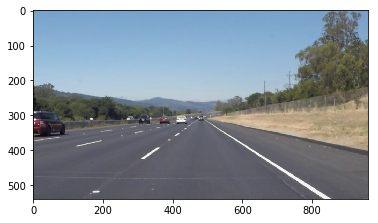

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [20]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def _get_left_right_point(points):
    """Given a list of points, return the left most and right most points.
    """
    left, right = None, None
    for x, y in points:
        if left is None or left[0] > x:
            left = (x, y)
        if right is None or right[0] < x:
            right = (x, y)
    return left, right


def _get_x2(slope, x1, y1, y2):
    return int((y2 - y1) / slope + x1)


def draw_lines(img, lines, color=[255, 0, 0], thickness=5):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    left_slopes = []
    right_slopes = []
    sizey = img.shape[0]
    slope_threshold = 0.1
    left_line_start, left_line_end, right_line_start, right_line_end = [None] * 4
    left_line_points = []
    right_line_points = []
    cal_slope = lambda seg: (seg[3] - seg[1]) / (seg[2] - seg[0])
    left_slopes = [cal_slope(seg) for line in lines for seg in line if cal_slope(seg) < 0]
    right_slopes = [cal_slope(seg) for line in lines for seg in line if cal_slope(seg) > 0]
    left_slope = np.median(left_slopes)
    right_slope = np.median(right_slopes)
    # filter out bad line segments
    for line in lines:
        for x1, y1, x2, y2 in line:
            slope = cal_slope((x1, y1, x2, y2))
            if slope < 0 and abs(slope - left_slope) < slope_threshold:
                left_line_points.extend([(x1, y1), (x2, y2)])
            elif slope > 0 and abs(slope - right_slope) < slope_threshold:
                right_line_points.extend([(x1, y1), (x2, y2)])
    _, left_line_start = _get_left_right_point(left_line_points)
    right_line_start, _ = _get_left_right_point(right_line_points)
    left_line_end = (_get_x2(left_slope, left_line_start[0], left_line_start[1], sizey), sizey)
    right_line_end = (_get_x2(right_slope, right_line_start[0], right_line_start[1], sizey), sizey)
    cv2.line(img, right_line_start, right_line_end, color, thickness)
    cv2.line(img, left_line_start, left_line_end, color, thickness)


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['whiteCarLaneSwitch.jpg',
 'solidYellowCurve.jpg',
 'solidWhiteCurve.jpg',
 'solidYellowLeft.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve2.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

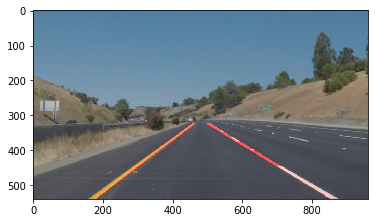

In [21]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.
def get_vertices(xsize, ysize):
    lower_left = (xsize * 1/15, ysize)
    lower_right = (xsize * 19/20, ysize)
    upper_left = (xsize * 3/7, ysize * 3/5)
    upper_right = (xsize * 4/7, ysize * 3/5)
    return np.array([[upper_left, lower_left, 
                      lower_right, upper_right]], 
                    dtype=np.int32)

rho = 2
theta = np.pi/180
threshold = 20
min_line_length = 5
max_line_gap = 10

for root, dirs, files in os.walk("test_images"):
    for f in files:
        filename = os.path.join(root, f)
        image = mpimg.imread(filename)
        ysize = image.shape[0]
        xsize = image.shape[1]
        new_image = np.copy(image)
        gray = grayscale(new_image)
        gray = gaussian_blur(gray, 5)
        edges = canny(gray, 100, 200)
        edges = region_of_interest(edges, get_vertices(xsize, ysize))
        lines = hough_lines(edges, rho, theta, threshold, min_line_length, max_line_gap)
        final = weighted_img(lines, new_image)
        plt.imshow(final)
        new_path = os.path.join("test_images_output", f)
        plt.imsave(new_path, final, format="jpeg")
        

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [22]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    ysize = image.shape[0]
    xsize = image.shape[1]
    new_image = np.copy(image)
    gray = grayscale(new_image)
    gray = gaussian_blur(gray, 5)
    edges = canny(gray, 100, 200)
    edges = region_of_interest(edges, get_vertices(xsize, ysize))
    lines = hough_lines(edges, rho, theta, threshold, min_line_length, max_line_gap)
    result = weighted_img(lines, new_image)
    return result

Let's try the one with the solid white lane on the right first ...

In [23]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:03<00:00, 55.78it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 3.49 s, sys: 240 ms, total: 3.73 s
Wall time: 4.52 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [24]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [25]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:12<00:00, 53.65it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 11 s, sys: 644 ms, total: 11.6 s
Wall time: 13.2 s


In [26]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [12]:
challenge_output = 'test_videos_output/challenge.mp4'
clip2 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

-0.615384615385 0.520733652313
-0.649425287356 ------  399 587 573 474
[[399 587 573 474]]
******************** [(758, 477), (779, 489), (942, 588), (1046, 648), (399, 587), (573, 474)]
-0.694444444444 ------  255 686 363 611
[[255 686 363 611]]
******************** [(758, 477), (779, 489), (942, 588), (1046, 648), (399, 587), (573, 474), (945, 600), (1073, 677), (255, 686), (363, 611)]
-0.622950819672 ------  555 491 616 453
[[555 491 616 453]]
******************** [(758, 477), (779, 489), (942, 588), (1046, 648), (399, 587), (573, 474), (945, 600), (1073, 677), (255, 686), (363, 611), (555, 491), (616, 453)]
-0.681818181818 ------  277 686 343 641
[[277 686 343 641]]
******************** [(758, 477), (779, 489), (942, 588), (1046, 648), (399, 587), (573, 474), (945, 600), (1073, 677), (255, 686), (363, 611), (555, 491), (616, 453), (1062, 658), (1095, 675), (927, 589), (995, 629), (277, 686), (343, 641)]
-0.555555555556 ------  583 468 628 443
[[583 468 628 443]]
********************

  1%|          | 2/251 [00:00<00:15, 16.41it/s]

-0.615384615385 0.520733652313
-0.649425287356 ------  399 587 573 474
[[399 587 573 474]]
******************** [(758, 477), (779, 489), (942, 588), (1046, 648), (399, 587), (573, 474)]
-0.694444444444 ------  255 686 363 611
[[255 686 363 611]]
******************** [(758, 477), (779, 489), (942, 588), (1046, 648), (399, 587), (573, 474), (945, 600), (1073, 677), (255, 686), (363, 611)]
-0.622950819672 ------  555 491 616 453
[[555 491 616 453]]
******************** [(758, 477), (779, 489), (942, 588), (1046, 648), (399, 587), (573, 474), (945, 600), (1073, 677), (255, 686), (363, 611), (555, 491), (616, 453)]
-0.681818181818 ------  277 686 343 641
[[277 686 343 641]]
******************** [(758, 477), (779, 489), (942, 588), (1046, 648), (399, 587), (573, 474), (945, 600), (1073, 677), (255, 686), (363, 611), (555, 491), (616, 453), (1062, 658), (1095, 675), (927, 589), (995, 629), (277, 686), (343, 641)]
-0.555555555556 ------  583 468 628 443
[[583 468 628 443]]
********************

  2%|▏         | 4/251 [00:00<00:15, 16.10it/s]

-0.652173913043 ------  443 568 512 523
[[443 568 512 523]]
******************** [(542, 500), (605, 459), (376, 603), (596, 460), (539, 502), (583, 474), (602, 462), (636, 440), (343, 626), (390, 595), (582, 470), (598, 459), (259, 683), (301, 656), (342, 642), (375, 619), (486, 539), (525, 514), (443, 568), (512, 523)]
-0.666666666667 ------  314 662 347 640
[[314 662 347 640]]
******************** [(542, 500), (605, 459), (376, 603), (596, 460), (539, 502), (583, 474), (602, 462), (636, 440), (343, 626), (390, 595), (582, 470), (598, 459), (259, 683), (301, 656), (342, 642), (375, 619), (486, 539), (525, 514), (443, 568), (512, 523), (771, 489), (794, 506), (314, 662), (347, 640)]
-0.620689655172 ------  305 652 334 634
[[305 652 334 634]]
******************** [(542, 500), (605, 459), (376, 603), (596, 460), (539, 502), (583, 474), (602, 462), (636, 440), (343, 626), (390, 595), (582, 470), (598, 459), (259, 683), (301, 656), (342, 642), (375, 619), (486, 539), (525, 514), (443, 568)

  2%|▏         | 6/251 [00:00<00:16, 15.12it/s]

 532
[[477 540 490 532]]
******************** [(313, 664), (597, 465), (360, 618), (554, 488), (793, 499), (836, 527), (284, 668), (373, 608), (592, 465), (614, 451), (943, 598), (953, 604), (801, 509), (827, 527), (536, 501), (595, 462), (639, 444), (649, 437), (345, 628), (399, 591), (261, 685), (296, 660), (298, 675), (326, 656), (833, 523), (838, 526), (731, 463), (741, 469), (945, 595), (956, 602), (958, 596), (966, 601), (302, 657), (320, 644), (796, 500), (821, 515), (731, 462), (743, 469), (534, 507), (544, 501), (321, 659), (361, 631), (805, 512), (823, 525), (733, 461), (741, 466), (284, 685), (509, 527), (259, 685), (299, 659), (402, 589), (470, 546), (734, 461), (743, 467), (550, 496), (576, 480), (941, 594), (952, 601), (287, 684), (307, 670), (477, 540), (490, 532)]
******************** [(313, 664), (597, 465), (360, 618), (554, 488), (793, 499), (836, 527), (284, 668), (373, 608), (592, 465), (614, 451), (943, 598), (953, 604), (801, 509), (827, 527), (536, 501), (595, 4

  4%|▎         | 9/251 [00:00<00:15, 15.74it/s]

684 326 661
[[291 684 326 661]]
******************** [(406, 589), (600, 458), (339, 635), (401, 594), (824, 522), (896, 569), (523, 515), (609, 457), (739, 468), (753, 476), (263, 685), (316, 652), (831, 521), (910, 568), (476, 549), (521, 518), (411, 598), (451, 569), (304, 675), (355, 640), (386, 603), (404, 592), (323, 646), (350, 629), (471, 553), (482, 546), (424, 589), (432, 584), (842, 528), (902, 564), (292, 684), (302, 678), (451, 568), (500, 533), (729, 460), (740, 467), (437, 567), (584, 468), (431, 584), (436, 581), (291, 684), (326, 661)]
-0.6 ------  420 592 425 589
[[420 592 425 589]]
******************** [(406, 589), (600, 458), (339, 635), (401, 594), (824, 522), (896, 569), (523, 515), (609, 457), (739, 468), (753, 476), (263, 685), (316, 652), (831, 521), (910, 568), (476, 549), (521, 518), (411, 598), (451, 569), (304, 675), (355, 640), (386, 603), (404, 592), (323, 646), (350, 629), (471, 553), (482, 546), (424, 589), (432, 584), (842, 528), (902, 564), (292, 684),

  5%|▍         | 12/251 [00:00<00:13, 17.83it/s]

-0.538461538462 0.569620253165
-0.512195121951 ------  596 466 637 445
[[596 466 637 445]]
******************** [(863, 549), (985, 625), (870, 546), (949, 591), (596, 466), (637, 445)]
-0.565217391304 ------  573 476 596 463
[[573 476 596 463]]
******************** [(863, 549), (985, 625), (870, 546), (949, 591), (596, 466), (637, 445), (573, 476), (596, 463)]
-0.625 ------  413 560 421 555
[[413 560 421 555]]
******************** [(863, 549), (985, 625), (870, 546), (949, 591), (596, 466), (637, 445), (573, 476), (596, 463), (413, 560), (421, 555)]
-0.555555555556 ------  411 557 420 552
[[411 557 420 552]]
******************** [(863, 549), (985, 625), (870, 546), (949, 591), (596, 466), (637, 445), (573, 476), (596, 463), (413, 560), (421, 555), (411, 557), (420, 552)]
-0.538461538462 ------  589 466 628 445
[[589 466 628 445]]
******************** [(863, 549), (985, 625), (870, 546), (949, 591), (596, 466), (637, 445), (573, 476), (596, 463), (413, 560), (421, 555), (411, 557), (420

  6%|▌         | 15/251 [00:00<00:12, 19.11it/s]

[[271 685 560 483]]
******************** [(271, 685), (560, 483)]
-0.700325732899 ------  274 684 581 469
[[274 684 581 469]]
******************** [(271, 685), (560, 483), (969, 611), (1072, 675), (982, 609), (1066, 657), (274, 684), (581, 469)]
-0.564102564103 ------  583 468 622 446
[[583 468 622 446]]
******************** [(271, 685), (560, 483), (969, 611), (1072, 675), (982, 609), (1066, 657), (274, 684), (581, 469), (763, 480), (788, 494), (1042, 655), (1077, 677), (583, 468), (622, 446)]
-0.533333333333 ------  282 634 297 626
[[282 634 297 626]]
******************** [(271, 685), (560, 483), (969, 611), (1072, 675), (982, 609), (1066, 657), (274, 684), (581, 469), (763, 480), (788, 494), (1042, 655), (1077, 677), (583, 468), (622, 446), (759, 482), (785, 497), (1080, 665), (1095, 674), (1071, 658), (1079, 662), (983, 609), (1036, 639), (282, 634), (297, 626)]
-0.56 ------  585 471 610 457
[[585 471 610 457]]
******************** [(271, 685), (560, 483), (969, 611), (1072, 675), 

  7%|▋         | 18/251 [00:00<00:11, 20.61it/s]

-0.365853658537 0.6
-0.4375 ------  628 448 644 441
[[628 448 644 441]]
******************** [(779, 489), (810, 509), (777, 494), (791, 502), (628, 448), (644, 441)]
-0.365853658537 ------  615 449 656 434
[[615 449 656 434]]
******************** [(779, 489), (810, 509), (777, 494), (791, 502), (628, 448), (644, 441), (795, 505), (802, 509), (877, 554), (886, 560), (615, 449), (656, 434)]
-0.347826086957 ------  629 447 652 439
[[629 447 652 439]]
******************** [(779, 489), (810, 509), (777, 494), (791, 502), (628, 448), (644, 441), (795, 505), (802, 509), (877, 554), (886, 560), (615, 449), (656, 434), (730, 460), (736, 464), (772, 490), (782, 496), (879, 554), (887, 559), (885, 555), (890, 558), (884, 555), (889, 558), (629, 447), (652, 439)]
******************** [(779, 489), (810, 509), (777, 494), (791, 502), (628, 448), (644, 441), (795, 505), (802, 509), (877, 554), (886, 560), (615, 449), (656, 434), (730, 460), (736, 464), (772, 490), (782, 496), (879, 554), (887, 559), 

  8%|▊         | 21/251 [00:01<00:12, 18.13it/s]

-0.666666666667 0.588235294118
-0.701149425287 ------  411 586 498 525
[[411 586 498 525]]
******************** [(411, 586), (498, 525)]
-0.753086419753 ------  413 597 494 536
[[413 597 494 536]]
******************** [(411, 586), (498, 525), (413, 597), (494, 536)]
-0.672727272727 ------  540 502 595 465
[[540 502 595 465]]
******************** [(411, 586), (498, 525), (413, 597), (494, 536), (540, 502), (595, 465)]
-0.678571428571 ------  561 483 589 464
[[561 483 589 464]]
******************** [(411, 586), (498, 525), (413, 597), (494, 536), (540, 502), (595, 465), (561, 483), (589, 464)]
-0.647058823529 ------  515 513 549 491
[[515 513 549 491]]
******************** [(411, 586), (498, 525), (413, 597), (494, 536), (540, 502), (595, 465), (561, 483), (589, 464), (515, 513), (549, 491)]
-0.688888888889 ------  300 666 345 635
[[300 666 345 635]]
******************** [(411, 586), (498, 525), (413, 597), (494, 536), (540, 502), (595, 465), (561, 483), (589, 464), (515, 513), (549, 491

  9%|▉         | 23/251 [00:01<00:12, 17.79it/s]

-0.6 0.591666666667
-0.683168316832 ------  426 574 527 505
[[426 574 527 505]]
******************** [(426, 574), (527, 505)]
-0.621621621622 ------  529 502 603 456
[[529 502 603 456]]
******************** [(426, 574), (527, 505), (850, 534), (954, 594), (529, 502), (603, 456)]
-0.625 ------  590 468 606 458
[[590 468 606 458]]
******************** [(426, 574), (527, 505), (850, 534), (954, 594), (529, 502), (603, 456), (840, 534), (939, 596), (590, 468), (606, 458)]
-0.684210526316 ------  360 621 417 582
[[360 621 417 582]]
******************** [(426, 574), (527, 505), (850, 534), (954, 594), (529, 502), (603, 456), (840, 534), (939, 596), (590, 468), (606, 458), (360, 621), (417, 582)]
-0.647058823529 ------  421 578 438 567
[[421 578 438 567]]
******************** [(426, 574), (527, 505), (850, 534), (954, 594), (529, 502), (603, 456), (840, 534), (939, 596), (590, 468), (606, 458), (360, 621), (417, 582), (421, 578), (438, 567)]
-0.695652173913 ------  373 626 396 610
[[373 626 3

 10%|▉         | 25/251 [00:01<00:12, 17.52it/s]

 611 456
[[553 491 611 456]]
******************** [(923, 588), (1072, 677), (934, 585), (1090, 675), (592, 466), (627, 450), (937, 586), (1092, 675), (573, 473), (616, 450), (761, 479), (781, 492), (629, 449), (661, 433), (546, 490), (562, 481), (319, 609), (338, 599), (620, 453), (633, 446), (755, 481), (775, 494), (927, 591), (937, 597), (553, 491), (611, 456)]
-0.5 ------  600 459 632 443
[[600 459 632 443]]
******************** [(923, 588), (1072, 677), (934, 585), (1090, 675), (592, 466), (627, 450), (937, 586), (1092, 675), (573, 473), (616, 450), (761, 479), (781, 492), (629, 449), (661, 433), (546, 490), (562, 481), (319, 609), (338, 599), (620, 453), (633, 446), (755, 481), (775, 494), (927, 591), (937, 597), (553, 491), (611, 456), (600, 459), (632, 443)]
-0.5 ------  318 606 338 596
[[318 606 338 596]]
******************** [(923, 588), (1072, 677), (934, 585), (1090, 675), (592, 466), (627, 450), (937, 586), (1092, 675), (573, 473), (616, 450), (761, 479), (781, 492), (629, 

 11%|█         | 28/251 [00:01<00:12, 18.15it/s]

-0.4375 0.666666666667
-0.5 ------  560 481 570 476
[[560 481 570 476]]
******************** [(560, 481), (570, 476)]
-0.5 ------  577 475 595 466
[[577 475 595 466]]
******************** [(560, 481), (570, 476), (577, 475), (595, 466)]
-0.473684210526 ------  578 470 597 461
[[578 470 597 461]]
******************** [(560, 481), (570, 476), (577, 475), (595, 466), (578, 470), (597, 461)]
-0.470588235294 ------  589 468 623 452
[[589 468 623 452]]
******************** [(560, 481), (570, 476), (577, 475), (595, 466), (578, 470), (597, 461), (589, 468), (623, 452)]
-0.416666666667 ------  595 461 607 456
[[595 461 607 456]]
******************** [(560, 481), (570, 476), (577, 475), (595, 466), (578, 470), (597, 461), (589, 468), (623, 452), (595, 461), (607, 456)]
-0.366666666667 ------  627 449 657 438
[[627 449 657 438]]
******************** [(560, 481), (570, 476), (577, 475), (595, 466), (578, 470), (597, 461), (589, 468), (623, 452), (595, 461), (607, 456), (780, 491), (810, 510), (77

 12%|█▏        | 30/251 [00:01<00:12, 17.39it/s]

 516 523 505
[[505 516 523 505]]
******************** [(589, 469), (617, 453), (467, 543), (493, 526), (916, 578), (923, 582), (718, 448), (744, 465), (622, 452), (640, 443), (555, 484), (622, 447), (784, 495), (824, 520), (779, 497), (814, 520), (505, 516), (523, 505)]
-0.625 ------  478 535 494 525
[[478 535 494 525]]
******************** [(589, 469), (617, 453), (467, 543), (493, 526), (916, 578), (923, 582), (718, 448), (744, 465), (622, 452), (640, 443), (555, 484), (622, 447), (784, 495), (824, 520), (779, 497), (814, 520), (505, 516), (523, 505), (478, 535), (494, 525)]
-0.6 ------  616 451 626 445
[[616 451 626 445]]
******************** [(589, 469), (617, 453), (467, 543), (493, 526), (916, 578), (923, 582), (718, 448), (744, 465), (622, 452), (640, 443), (555, 484), (622, 447), (784, 495), (824, 520), (779, 497), (814, 520), (505, 516), (523, 505), (478, 535), (494, 525), (616, 451), (626, 445)]
-0.583333333333 ------  495 523 507 516
[[495 523 507 516]]
******************** 

 13%|█▎        | 33/251 [00:01<00:12, 17.39it/s]

-0.647058823529 0.642857142857
-0.698744769874 ------  265 684 504 517
[[265 684 504 517]]
******************** [(265, 684), (504, 517)]
-0.733333333333 ------  304 672 424 584
[[304 672 424 584]]
******************** [(265, 684), (504, 517), (304, 672), (424, 584)]
-0.700787401575 ------  435 574 562 485
[[435 574 562 485]]
******************** [(265, 684), (504, 517), (304, 672), (424, 584), (435, 574), (562, 485)]
-0.576923076923 ------  530 500 608 455
[[530 500 608 455]]
******************** [(265, 684), (504, 517), (304, 672), (424, 584), (435, 574), (562, 485), (530, 500), (608, 455)]
-0.69696969697 ------  612 458 645 435
[[612 458 645 435]]
******************** [(265, 684), (504, 517), (304, 672), (424, 584), (435, 574), (562, 485), (530, 500), (608, 455), (834, 526), (918, 578), (882, 563), (905, 579), (612, 458), (645, 435)]
-0.666666666667 ------  604 462 631 444
[[604 462 631 444]]
******************** [(265, 684), (504, 517), (304, 672), (424, 584), (435, 574), (562, 485)

 14%|█▍        | 35/251 [00:01<00:12, 16.89it/s]

-0.637626262626 0.6
-0.701030927835 ------  372 620 566 484
[[372 620 566 484]]
******************** [(372, 620), (566, 484)]
-0.683544303797 ------  302 656 381 602
[[302 656 381 602]]
******************** [(372, 620), (566, 484), (302, 656), (381, 602)]
-0.648854961832 ------  425 570 556 485
[[425 570 556 485]]
******************** [(372, 620), (566, 484), (302, 656), (381, 602), (878, 553), (1019, 637), (425, 570), (556, 485)]
-0.716981132075 ------  305 670 358 632
[[305 670 358 632]]
******************** [(372, 620), (566, 484), (302, 656), (381, 602), (878, 553), (1019, 637), (425, 570), (556, 485), (865, 554), (984, 629), (305, 670), (358, 632)]
-0.636363636364 ------  538 497 560 483
[[538 497 560 483]]
******************** [(372, 620), (566, 484), (302, 656), (381, 602), (878, 553), (1019, 637), (425, 570), (556, 485), (865, 554), (984, 629), (305, 670), (358, 632), (538, 497), (560, 483)]
-0.638888888889 ------  405 584 441 561
[[405 584 441 561]]
******************** [(372,

 15%|█▍        | 37/251 [00:02<00:14, 14.95it/s]

------  616 456 632 445
[[616 456 632 445]]
******************** [(391, 593), (485, 531), (355, 631), (555, 491), (942, 592), (1087, 675), (984, 629), (1064, 677), (565, 486), (587, 471), (562, 483), (594, 463), (465, 543), (585, 468), (317, 659), (450, 565), (600, 465), (638, 442), (931, 594), (991, 633), (946, 593), (1018, 635), (298, 673), (337, 646), (342, 626), (386, 598), (725, 456), (745, 469), (282, 685), (297, 675), (995, 634), (1055, 671), (402, 586), (424, 572), (590, 466), (633, 444), (759, 480), (783, 494), (756, 482), (766, 488), (629, 450), (654, 435), (488, 536), (519, 515), (588, 471), (603, 463), (308, 613), (326, 602), (502, 526), (576, 478), (304, 612), (319, 602), (293, 677), (301, 672), (964, 615), (1001, 639), (756, 483), (781, 496), (1029, 643), (1087, 676), (504, 517), (521, 507), (381, 600), (399, 589), (616, 456), (632, 445)]
******************** [(391, 593), (485, 531), (355, 631), (555, 491), (942, 592), (1087, 675), (984, 629), (1064, 677), (565, 486), (58

 16%|█▌        | 39/251 [00:02<00:13, 15.24it/s]

-0.583333333333 0.6
-0.674418604651 ------  408 581 494 523
[[408 581 494 523]]
******************** [(408, 581), (494, 523)]
-0.638888888889 ------  335 631 371 608
[[335 631 371 608]]
******************** [(408, 581), (494, 523), (335, 631), (371, 608)]
-0.649572649573 ------  481 540 598 464
[[481 540 598 464]]
******************** [(408, 581), (494, 523), (335, 631), (371, 608), (481, 540), (598, 464)]
-0.636363636364 ------  517 510 572 475
[[517 510 572 475]]
******************** [(408, 581), (494, 523), (335, 631), (371, 608), (481, 540), (598, 464), (517, 510), (572, 475)]
-0.541666666667 ------  571 476 595 463
[[571 476 595 463]]
******************** [(408, 581), (494, 523), (335, 631), (371, 608), (481, 540), (598, 464), (517, 510), (572, 475), (571, 476), (595, 463)]
-0.619047619048 ------  373 605 394 592
[[373 605 394 592]]
******************** [(408, 581), (494, 523), (335, 631), (371, 608), (481, 540), (598, 464), (517, 510), (572, 475), (571, 476), (595, 463), (774, 48

 16%|█▋        | 41/251 [00:02<00:13, 15.25it/s]

-0.642857142857 0.592682926829
-0.571428571429 ------  619 451 626 447
[[619 451 626 447]]
******************** [(619, 451), (626, 447)]
-0.641975308642 ------  491 528 572 476
[[491 528 572 476]]
******************** [(619, 451), (626, 447), (491, 528), (572, 476)]
-0.7 ------  383 611 523 513
[[383 611 523 513]]
******************** [(619, 451), (626, 447), (491, 528), (572, 476), (383, 611), (523, 513)]
-0.709677419355 ------  324 654 417 588
[[324 654 417 588]]
******************** [(619, 451), (626, 447), (491, 528), (572, 476), (383, 611), (523, 513), (324, 654), (417, 588)]
-0.674796747967 ------  342 626 465 543
[[342 626 465 543]]
******************** [(619, 451), (626, 447), (491, 528), (572, 476), (383, 611), (523, 513), (324, 654), (417, 588), (342, 626), (465, 543)]
-0.662162162162 ------  326 637 400 588
[[326 637 400 588]]
******************** [(619, 451), (626, 447), (491, 528), (572, 476), (383, 611), (523, 513), (324, 654), (417, 588), (342, 626), (465, 543), (326, 63

 17%|█▋        | 43/251 [00:02<00:12, 16.12it/s]

 353 620
[[317 643 353 620]]
******************** [(317, 643), (353, 620)]
-0.6 ------  578 474 613 453
[[578 474 613 453]]
******************** [(317, 643), (353, 620), (578, 474), (613, 453)]
-0.646153846154 ------  426 569 491 527
[[426 569 491 527]]
******************** [(317, 643), (353, 620), (578, 474), (613, 453), (426, 569), (491, 527)]
-0.661764705882 ------  465 553 533 508
[[465 553 533 508]]
******************** [(317, 643), (353, 620), (578, 474), (613, 453), (426, 569), (491, 527), (465, 553), (533, 508)]
-0.611111111111 ------  536 504 590 471
[[536 504 590 471]]
******************** [(317, 643), (353, 620), (578, 474), (613, 453), (426, 569), (491, 527), (465, 553), (533, 508), (536, 504), (590, 471)]
-0.56 ------  573 480 598 466
[[573 480 598 466]]
******************** [(317, 643), (353, 620), (578, 474), (613, 453), (426, 569), (491, 527), (465, 553), (533, 508), (536, 504), (590, 471), (798, 504), (847, 532), (573, 480), (598, 466)]
-0.650793650794 ------  398 588 

 18%|█▊        | 45/251 [00:02<00:12, 16.14it/s]

-0.4375 0.555555555556
-0.533333333333 ------  579 473 624 449
[[579 473 624 449]]
******************** [(905, 577), (963, 612), (746, 475), (761, 484), (863, 542), (951, 594), (579, 473), (624, 449)]
-0.5 ------  426 550 434 546
[[426 550 434 546]]
******************** [(905, 577), (963, 612), (746, 475), (761, 484), (863, 542), (951, 594), (579, 473), (624, 449), (851, 544), (904, 575), (724, 455), (738, 463), (426, 550), (434, 546)]
-0.5 ------  568 480 578 475
[[568 480 578 475]]
******************** [(905, 577), (963, 612), (746, 475), (761, 484), (863, 542), (951, 594), (579, 473), (624, 449), (851, 544), (904, 575), (724, 455), (738, 463), (426, 550), (434, 546), (568, 480), (578, 475)]
-0.526315789474 ------  644 442 663 432
[[644 442 663 432]]
******************** [(905, 577), (963, 612), (746, 475), (761, 484), (863, 542), (951, 594), (579, 473), (624, 449), (851, 544), (904, 575), (724, 455), (738, 463), (426, 550), (434, 546), (568, 480), (578, 475), (917, 573), (980, 610),

 20%|█▉        | 49/251 [00:02<00:15, 13.18it/s]

-0.5 0.6
-0.571428571429 ------  354 588 368 580
[[354 588 368 580]]
******************** [(917, 574), (1092, 675), (905, 576), (1075, 678), (354, 588), (368, 580)]
-0.483870967742 ------  596 463 627 448
[[596 463 627 448]]
******************** [(917, 574), (1092, 675), (905, 576), (1075, 678), (354, 588), (368, 580), (596, 463), (627, 448)]
-0.470588235294 ------  596 467 613 459
[[596 467 613 459]]
******************** [(917, 574), (1092, 675), (905, 576), (1075, 678), (354, 588), (368, 580), (596, 463), (627, 448), (596, 467), (613, 459)]
-0.40625 ------  613 458 645 445
[[613 458 645 445]]
******************** [(917, 574), (1092, 675), (905, 576), (1075, 678), (354, 588), (368, 580), (596, 463), (627, 448), (596, 467), (613, 459), (613, 458), (645, 445)]
-0.528301886792 ------  571 478 624 450
[[571 478 624 450]]
******************** [(917, 574), (1092, 675), (905, 576), (1075, 678), (354, 588), (368, 580), (596, 463), (627, 448), (596, 467), (613, 459), (613, 458), (645, 445), (1

 22%|██▏       | 55/251 [00:03<00:12, 16.32it/s]

-0.645104895105 0.625
-0.732142857143 ------  295 684 351 643
[[295 684 351 643]]
******************** [(295, 684), (351, 643)]
-0.666666666667 ------  604 460 613 454
[[604 460 613 454]]
******************** [(295, 684), (351, 643), (604, 460), (613, 454)]
-0.679347826087 ------  329 642 513 517
[[329 642 513 517]]
******************** [(295, 684), (351, 643), (604, 460), (613, 454), (329, 642), (513, 517)]
-0.714285714286 ------  608 458 615 453
[[608 458 615 453]]
******************** [(295, 684), (351, 643), (604, 460), (613, 454), (329, 642), (513, 517), (608, 458), (615, 453)]
-0.743243243243 ------  482 547 556 492
[[482 547 556 492]]
******************** [(295, 684), (351, 643), (604, 460), (613, 454), (329, 642), (513, 517), (608, 458), (615, 453), (482, 547), (556, 492)]
-0.681818181818 ------  604 464 648 434
[[604 464 648 434]]
******************** [(295, 684), (351, 643), (604, 460), (613, 454), (329, 642), (513, 517), (608, 458), (615, 453), (482, 547), (556, 492), (604, 

 23%|██▎       | 57/251 [00:03<00:11, 16.77it/s]

-0.636363636364 ------  488 532 499 525
[[488 532 499 525]]
******************** [(622, 451), (650, 434), (827, 522), (904, 566), (638, 440), (648, 434), (819, 523), (889, 568), (488, 532), (499, 525)]
-0.65 ------  429 573 449 560
[[429 573 449 560]]
******************** [(622, 451), (650, 434), (827, 522), (904, 566), (638, 440), (648, 434), (819, 523), (889, 568), (488, 532), (499, 525), (429, 573), (449, 560)]
-0.5625 ------  562 488 626 452
[[562 488 626 452]]
******************** [(622, 451), (650, 434), (827, 522), (904, 566), (638, 440), (648, 434), (819, 523), (889, 568), (488, 532), (499, 525), (429, 573), (449, 560), (562, 488), (626, 452)]
-0.528571428571 ------  562 483 632 446
[[562 483 632 446]]
******************** [(622, 451), (650, 434), (827, 522), (904, 566), (638, 440), (648, 434), (819, 523), (889, 568), (488, 532), (499, 525), (429, 573), (449, 560), (562, 488), (626, 452), (562, 483), (632, 446)]
-0.615384615385 ------  479 547 492 539
[[479 547 492 539]]
******

 25%|██▍       | 62/251 [00:03<00:10, 17.98it/s]

389 571 399 566
[[389 571 399 566]]
******************** [(905, 568), (927, 581), (881, 562), (964, 612), (930, 581), (937, 585), (939, 588), (1024, 636), (593, 469), (635, 448), (957, 608), (1006, 639), (1002, 635), (1046, 663), (556, 487), (613, 454), (952, 605), (978, 622), (602, 461), (641, 440), (546, 493), (558, 487), (756, 475), (775, 486), (938, 587), (976, 608), (532, 502), (540, 498), (806, 509), (812, 512), (937, 597), (947, 602), (992, 619), (1036, 643), (893, 560), (904, 566), (728, 456), (745, 466), (892, 560), (924, 578), (903, 576), (917, 584), (538, 498), (550, 492), (1018, 634), (1032, 641), (757, 479), (774, 489), (626, 438), (638, 444), (386, 569), (398, 562), (553, 494), (559, 491), (888, 559), (946, 591), (728, 455), (743, 464), (914, 583), (932, 593), (1050, 652), (1065, 659), (389, 571), (399, 566)]
******************** [(905, 568), (927, 581), (881, 562), (964, 612), (930, 581), (937, 585), (939, 588), (1024, 636), (593, 469), (635, 448), (957, 608), (1006, 639

 25%|██▌       | 64/251 [00:03<00:11, 16.99it/s]

 ------  387 599 411 584
[[387 599 411 584]]
******************** [(293, 665), (384, 603), (425, 573), (582, 471), (549, 497), (605, 462), (379, 605), (407, 587), (335, 651), (391, 611), (783, 490), (812, 509), (289, 685), (329, 657), (507, 526), (557, 493), (319, 663), (349, 642), (734, 461), (757, 476), (776, 492), (805, 511), (405, 600), (419, 591), (531, 509), (575, 481), (362, 617), (392, 597), (609, 461), (639, 442), (602, 465), (618, 455), (480, 544), (498, 533), (448, 557), (559, 485), (413, 581), (447, 559), (778, 489), (813, 509), (387, 599), (411, 584)]
******************** [(293, 665), (384, 603), (425, 573), (582, 471), (549, 497), (605, 462), (379, 605), (407, 587), (335, 651), (391, 611), (783, 490), (812, 509), (289, 685), (329, 657), (507, 526), (557, 493), (319, 663), (349, 642), (734, 461), (757, 476), (776, 492), (805, 511), (405, 600), (419, 591), (531, 509), (575, 481), (362, 617), (392, 597), (609, 461), (639, 442), (602, 465), (618, 455), (480, 544), (498, 533),

 27%|██▋       | 68/251 [00:04<00:11, 15.46it/s]

 593 432
[[574 434 593 432]]
******************** [(375, 682), (409, 680), (711, 443), (754, 471), (538, 454), (554, 453), (803, 510), (853, 541), (292, 685), (323, 683), (504, 459), (518, 457), (808, 507), (862, 538), (544, 671), (574, 669), (996, 628), (1016, 639), (806, 510), (854, 541), (587, 447), (629, 437), (687, 668), (697, 667), (999, 632), (1024, 629), (574, 434), (593, 432)]
-0.15625 ------  627 448 659 443
[[627 448 659 443]]
******************** [(375, 682), (409, 680), (711, 443), (754, 471), (538, 454), (554, 453), (803, 510), (853, 541), (292, 685), (323, 683), (504, 459), (518, 457), (808, 507), (862, 538), (544, 671), (574, 669), (996, 628), (1016, 639), (806, 510), (854, 541), (587, 447), (629, 437), (687, 668), (697, 667), (999, 632), (1024, 629), (574, 434), (593, 432), (627, 448), (659, 443)]
-0.1 ------  622 451 632 450
[[622 451 632 450]]
******************** [(375, 682), (409, 680), (711, 443), (754, 471), (538, 454), (554, 453), (803, 510), (853, 541), (292, 6

 29%|██▉       | 73/251 [00:04<00:10, 17.06it/s]

-0.348416289593 0.555555555556
******************** [(871, 549), (1003, 631), (881, 549), (1022, 630), (759, 474), (775, 484), (757, 478), (771, 486), (870, 550), (878, 555), (803, 505), (809, 508), (883, 549), (927, 574), (754, 476), (772, 486), (870, 549), (906, 572), (983, 618), (1004, 631), (754, 475), (773, 486)]
(1022, 630) (754, 476)
-0.625 0.555799151344
-0.679611650485 ------  339 639 442 569
[[339 639 442 569]]
******************** [(339, 639), (442, 569)]
-0.710526315789 ------  551 501 589 474
[[551 501 589 474]]
******************** [(339, 639), (442, 569), (899, 567), (1083, 677), (730, 458), (747, 468), (975, 602), (1104, 674), (551, 501), (589, 474)]
-0.6 ------  598 466 628 448
[[598 466 628 448]]
******************** [(339, 639), (442, 569), (899, 567), (1083, 677), (730, 458), (747, 468), (975, 602), (1104, 674), (551, 501), (589, 474), (598, 466), (628, 448)]
-0.648351648352 ------  496 530 587 471
[[496 530 587 471]]
******************** [(339, 639), (442, 569), (8

 31%|███       | 77/251 [00:04<00:09, 17.78it/s]

-0.5625 0.555555555556
-0.565217391304 ------  580 476 626 450
[[580 476 626 450]]
******************** [(721, 449), (744, 463), (580, 476), (626, 450)]
-0.521739130435 ------  611 462 634 450
[[611 462 634 450]]
******************** [(721, 449), (744, 463), (580, 476), (626, 450), (611, 462), (634, 450)]
-0.653846153846 ------  215 678 241 661
[[215 678 241 661]]
******************** [(721, 449), (744, 463), (580, 476), (626, 450), (611, 462), (634, 450), (215, 678), (241, 661)]
-0.565217391304 ------  568 484 591 471
[[568 484 591 471]]
******************** [(721, 449), (744, 463), (580, 476), (626, 450), (611, 462), (634, 450), (215, 678), (241, 661), (733, 459), (760, 474), (568, 484), (591, 471)]
-0.625 ------  207 678 239 658
[[207 678 239 658]]
******************** [(721, 449), (744, 463), (580, 476), (626, 450), (611, 462), (634, 450), (215, 678), (241, 661), (733, 459), (760, 474), (568, 484), (591, 471), (783, 487), (812, 504), (1076, 655), (1107, 671), (207, 678), (239, 658)

 31%|███▏      | 79/251 [00:04<00:09, 17.79it/s]

-0.625 0.6
-0.721951219512 ------  293 682 498 534
[[293 682 498 534]]
******************** [(293, 682), (498, 534)]
-0.65625 ------  521 518 617 455
[[521 518 617 455]]
******************** [(293, 682), (498, 534), (521, 518), (617, 455)]
-0.625 ------  560 497 584 482
[[560 497 584 482]]
******************** [(293, 682), (498, 534), (521, 518), (617, 455), (822, 511), (880, 544), (836, 525), (869, 545), (1034, 639), (1046, 646), (813, 511), (846, 532), (560, 497), (584, 482)]
-0.653846153846 ------  500 533 526 516
[[500 533 526 516]]
******************** [(293, 682), (498, 534), (521, 518), (617, 455), (822, 511), (880, 544), (836, 525), (869, 545), (1034, 639), (1046, 646), (813, 511), (846, 532), (560, 497), (584, 482), (727, 455), (757, 473), (500, 533), (526, 516)]
-0.62962962963 ------  511 525 538 508
[[511 525 538 508]]
******************** [(293, 682), (498, 534), (521, 518), (617, 455), (822, 511), (880, 544), (836, 525), (869, 545), (1034, 639), (1046, 646), (813, 511), (8

 33%|███▎      | 83/251 [00:04<00:10, 15.47it/s]


[[310 685 334 683]]
******************** [(748, 471), (769, 484), (911, 569), (976, 605), (873, 539), (991, 604), (371, 682), (389, 681), (515, 469), (541, 467), (530, 443), (576, 437), (432, 676), (496, 672), (725, 455), (765, 477), (883, 553), (913, 569), (550, 440), (601, 434), (673, 456), (712, 454), (543, 438), (613, 432), (765, 478), (770, 481), (860, 540), (882, 551), (401, 681), (428, 677), (926, 576), (977, 605), (721, 454), (753, 472), (752, 469), (761, 474), (730, 456), (740, 462), (310, 685), (334, 683)]
-0.0714285714286 ------  534 464 548 463
[[534 464 548 463]]
******************** [(748, 471), (769, 484), (911, 569), (976, 605), (873, 539), (991, 604), (371, 682), (389, 681), (515, 469), (541, 467), (530, 443), (576, 437), (432, 676), (496, 672), (725, 455), (765, 477), (883, 553), (913, 569), (550, 440), (601, 434), (673, 456), (712, 454), (543, 438), (613, 432), (765, 478), (770, 481), (860, 540), (882, 551), (401, 681), (428, 677), (926, 576), (977, 605), (721, 454)

 35%|███▍      | 87/251 [00:05<00:09, 16.73it/s]

 543 465
[[509 476 543 465]]
******************** [(970, 593), (1116, 670), (958, 595), (1056, 651), (498, 475), (583, 448), (727, 458), (744, 468), (767, 484), (788, 496), (1020, 629), (1096, 674), (464, 488), (489, 481), (760, 479), (771, 485), (590, 447), (600, 444), (763, 477), (770, 481), (509, 476), (543, 465)]
-0.318181818182 ------  527 465 571 451
[[527 465 571 451]]
******************** [(970, 593), (1116, 670), (958, 595), (1056, 651), (498, 475), (583, 448), (727, 458), (744, 468), (767, 484), (788, 496), (1020, 629), (1096, 674), (464, 488), (489, 481), (760, 479), (771, 485), (590, 447), (600, 444), (763, 477), (770, 481), (509, 476), (543, 465), (975, 594), (1118, 670), (727, 455), (748, 468), (527, 465), (571, 451)]
-0.209302325581 ------  603 443 646 434
[[603 443 646 434]]
******************** [(970, 593), (1116, 670), (958, 595), (1056, 651), (498, 475), (583, 448), (727, 458), (744, 468), (767, 484), (788, 496), (1020, 629), (1096, 674), (464, 488), (489, 481), (760

 37%|███▋      | 92/251 [00:05<00:08, 17.80it/s]

 0.333333333333
-0.336633663366 ------  457 490 558 456
[[457 490 558 456]]
******************** [(457, 490), (558, 456)]
-0.294117647059 ------  616 442 633 437
[[616 442 633 437]]
******************** [(457, 490), (558, 456), (616, 442), (633, 437)]
-0.30303030303 ------  494 482 527 472
[[494 482 527 472]]
******************** [(457, 490), (558, 456), (616, 442), (633, 437), (494, 482), (527, 472)]
-0.315789473684 ------  547 460 566 454
[[547 460 566 454]]
******************** [(457, 490), (558, 456), (616, 442), (633, 437), (494, 482), (527, 472), (547, 460), (566, 454)]
-0.365384615385 ------  469 492 521 473
[[469 492 521 473]]
******************** [(457, 490), (558, 456), (616, 442), (633, 437), (494, 482), (527, 472), (547, 460), (566, 454), (469, 492), (521, 473)]
-0.375 ------  400 611 408 608
[[400 611 408 608]]
******************** [(457, 490), (558, 456), (616, 442), (633, 437), (494, 482), (527, 472), (547, 460), (566, 454), (469, 492), (521, 473), (400, 611), (408, 608)

 37%|███▋      | 94/251 [00:05<00:09, 17.31it/s]

-0.2 0.5
-0.285714285714 ------  519 467 603 443
[[519 467 603 443]]
******************** [(866, 543), (991, 615), (676, 432), (684, 436), (892, 550), (1003, 614), (519, 467), (603, 443)]
-0.111111111111 ------  558 440 567 439
[[558 440 567 439]]
******************** [(866, 543), (991, 615), (676, 432), (684, 436), (892, 550), (1003, 614), (519, 467), (603, 443), (558, 440), (567, 439)]
-0.13698630137 ------  535 442 608 432
[[535 442 608 432]]
******************** [(866, 543), (991, 615), (676, 432), (684, 436), (892, 550), (1003, 614), (519, 467), (603, 443), (558, 440), (567, 439), (535, 442), (608, 432)]
-0.114285714286 ------  376 587 411 583
[[376 587 411 583]]
******************** [(866, 543), (991, 615), (676, 432), (684, 436), (892, 550), (1003, 614), (519, 467), (603, 443), (558, 440), (567, 439), (535, 442), (608, 432), (376, 587), (411, 583)]
-0.16 ------  404 680 429 676
[[404 680 429 676]]
******************** [(866, 543), (991, 615), (676, 432), (684, 436), (892, 550), 

 39%|███▉      | 98/251 [00:05<00:09, 16.22it/s]

-0.2 ------  335 615 350 612
[[335 615 350 612]]
******************** [(532, 442), (599, 432), (548, 496), (566, 494), (522, 465), (626, 437), (1071, 677), (1098, 674), (496, 630), (508, 632), (736, 484), (744, 482), (822, 519), (832, 517), (536, 439), (584, 432), (335, 615), (350, 612)]
-0.125 ------  441 614 449 613
[[441 614 449 613]]
******************** [(532, 442), (599, 432), (548, 496), (566, 494), (522, 465), (626, 437), (1071, 677), (1098, 674), (496, 630), (508, 632), (736, 484), (744, 482), (822, 519), (832, 517), (536, 439), (584, 432), (335, 615), (350, 612), (441, 614), (449, 613)]
-0.125 ------  1078 677 1094 675
[[1078  677 1094  675]]
******************** [(532, 442), (599, 432), (548, 496), (566, 494), (522, 465), (626, 437), (1071, 677), (1098, 674), (496, 630), (508, 632), (736, 484), (744, 482), (822, 519), (832, 517), (536, 439), (584, 432), (335, 615), (350, 612), (441, 614), (449, 613), (1078, 677), (1094, 675)]
-0.181818181818 ------  429 616 440 614
[[429 616

 40%|███▉      | 100/251 [00:05<00:09, 15.44it/s]

[(367, 684), (452, 674), (530, 443), (592, 432), (412, 640), (502, 631), (522, 514), (555, 511), (423, 612), (464, 607), (779, 495), (803, 508), (783, 493), (792, 498), (877, 550), (884, 554), (787, 494), (811, 508), (420, 678), (479, 673), (724, 458), (730, 461), (475, 550), (496, 546), (461, 518), (487, 514), (745, 497), (779, 491), (776, 490), (781, 493), (727, 456), (732, 459), (801, 501), (811, 507), (386, 621), (405, 618), (443, 522), (457, 520)]
-0.214285714286 ------  878 552 892 549
[[878 552 892 549]]
******************** [(367, 684), (452, 674), (530, 443), (592, 432), (412, 640), (502, 631), (522, 514), (555, 511), (423, 612), (464, 607), (779, 495), (803, 508), (783, 493), (792, 498), (877, 550), (884, 554), (787, 494), (811, 508), (420, 678), (479, 673), (724, 458), (730, 461), (475, 550), (496, 546), (461, 518), (487, 514), (745, 497), (779, 491), (776, 490), (781, 493), (727, 456), (732, 459), (801, 501), (811, 507), (386, 621), (405, 618), (443, 522), (457, 520), (878,

 41%|████▏     | 104/251 [00:06<00:09, 15.60it/s]

[[533 441 567 436]]
******************** [(402, 548), (420, 546), (388, 553), (393, 552), (765, 515), (774, 514), (295, 701), (344, 692), (819, 512), (858, 533), (496, 541), (546, 534), (796, 507), (850, 534), (533, 441), (567, 436)]
-0.1 ------  535 536 555 534
[[535 536 555 534]]
******************** [(402, 548), (420, 546), (388, 553), (393, 552), (765, 515), (774, 514), (295, 701), (344, 692), (819, 512), (858, 533), (496, 541), (546, 534), (796, 507), (850, 534), (533, 441), (567, 436), (535, 536), (555, 534)]
-0.1 ------  362 558 382 556
[[362 558 382 556]]
******************** [(402, 548), (420, 546), (388, 553), (393, 552), (765, 515), (774, 514), (295, 701), (344, 692), (819, 512), (858, 533), (496, 541), (546, 534), (796, 507), (850, 534), (533, 441), (567, 436), (535, 536), (555, 534), (362, 558), (382, 556)]
-0.25 ------  585 445 601 441
[[585 445 601 441]]
******************** [(402, 548), (420, 546), (388, 553), (393, 552), (765, 515), (774, 514), (295, 701), (344, 692), 

 42%|████▏     | 106/251 [00:06<00:09, 15.63it/s]

-0.181818181818 0.5
-0.135135135135 ------  497 615 608 600
[[497 615 608 600]]
******************** [(497, 615), (608, 600)]
-0.134020618557 ------  264 645 361 632
[[264 645 361 632]]
******************** [(497, 615), (608, 600), (894, 559), (938, 582), (264, 645), (361, 632)]
-0.154545454545 ------  384 632 494 615
[[384 632 494 615]]
******************** [(497, 615), (608, 600), (894, 559), (938, 582), (264, 645), (361, 632), (384, 632), (494, 615)]
-0.15 ------  628 596 728 581
[[628 596 728 581]]
******************** [(497, 615), (608, 600), (894, 559), (938, 582), (264, 645), (361, 632), (384, 632), (494, 615), (717, 453), (723, 456), (628, 596), (728, 581)]
-0.16 ------  813 567 838 563
[[813 567 838 563]]
******************** [(497, 615), (608, 600), (894, 559), (938, 582), (264, 645), (361, 632), (384, 632), (494, 615), (717, 453), (723, 456), (628, 596), (728, 581), (813, 567), (838, 563)]
-0.16 ------  711 584 736 580
[[711 584 736 580]]
******************** [(497, 615), (6

 44%|████▍     | 110/251 [00:06<00:09, 14.22it/s]

 593 846 591
[[826 593 846 591]]
******************** [(962, 598), (1108, 672), (793, 634), (839, 622), (980, 616), (1027, 642), (647, 666), (799, 634), (1027, 644), (1050, 656), (793, 632), (800, 631), (826, 593), (846, 591)]
-0.205882352941 ------  674 664 708 657
[[674 664 708 657]]
******************** [(962, 598), (1108, 672), (793, 634), (839, 622), (980, 616), (1027, 642), (647, 666), (799, 634), (1027, 644), (1050, 656), (793, 632), (800, 631), (826, 593), (846, 591), (1027, 643), (1089, 676), (674, 664), (708, 657)]
-0.146341463415 ------  545 438 586 432
[[545 438 586 432]]
******************** [(962, 598), (1108, 672), (793, 634), (839, 622), (980, 616), (1027, 642), (647, 666), (799, 634), (1027, 644), (1050, 656), (793, 632), (800, 631), (826, 593), (846, 591), (1027, 643), (1089, 676), (674, 664), (708, 657), (545, 438), (586, 432)]
-0.125 ------  392 639 400 638
[[392 639 400 638]]
******************** [(962, 598), (1108, 672), (793, 634), (839, 622), (980, 616), (1027, 

 46%|████▌     | 116/251 [00:06<00:07, 19.28it/s]

-0.125 0.607142857143
-0.0512820512821 ------  676 439 715 437
[[676 439 715 437]]
******************** [(763, 479), (789, 495), (995, 623), (1009, 631), (994, 623), (1007, 631), (676, 439), (715, 437)]
-0.125 ------  881 597 889 596
[[881 597 889 596]]
******************** [(763, 479), (789, 495), (995, 623), (1009, 631), (994, 623), (1007, 631), (676, 439), (715, 437), (773, 490), (786, 497), (991, 623), (1000, 629), (992, 623), (1003, 630), (957, 599), (964, 603), (953, 600), (958, 603), (876, 546), (881, 549), (1004, 627), (1011, 631), (761, 479), (789, 496), (881, 597), (889, 596)]
******************** [(763, 479), (789, 495), (995, 623), (1009, 631), (994, 623), (1007, 631), (676, 439), (715, 437), (773, 490), (786, 497), (991, 623), (1000, 629), (992, 623), (1003, 630), (957, 599), (964, 603), (953, 600), (958, 603), (876, 546), (881, 549), (1004, 627), (1011, 631), (761, 479), (789, 496), (881, 597), (889, 596), (1013, 628), (1018, 631), (1012, 628), (1017, 631)]
(1018, 631) (6

 47%|████▋     | 119/251 [00:07<00:07, 17.87it/s]

-0.225683890578 0.575134168157
-0.3125 ------  459 487 507 472
[[459 487 507 472]]
******************** [(459, 487), (507, 472)]
-0.308510638298 ------  480 480 574 451
[[480 480 574 451]]
******************** [(459, 487), (507, 472), (813, 518), (878, 558), (738, 469), (751, 477), (819, 517), (862, 540), (480, 480), (574, 451)]
-0.135135135135 ------  1094 674 1131 669
[[1094  674 1131  669]]
******************** [(459, 487), (507, 472), (813, 518), (878, 558), (738, 469), (751, 477), (819, 517), (862, 540), (480, 480), (574, 451), (852, 536), (891, 555), (741, 468), (752, 475), (740, 472), (748, 477), (1094, 674), (1131, 669)]
-0.142857142857 ------  627 444 641 442
[[627 444 641 442]]
******************** [(459, 487), (507, 472), (813, 518), (878, 558), (738, 469), (751, 477), (819, 517), (862, 540), (480, 480), (574, 451), (852, 536), (891, 555), (741, 468), (752, 475), (740, 472), (748, 477), (1094, 674), (1131, 669), (627, 444), (641, 442)]
******************** [(459, 487), (507,

 50%|████▉     | 125/251 [00:07<00:06, 19.23it/s]

-0.145833333333 0.588235294118
-0.133333333333 ------  1114 671 1129 669
[[1114  671 1129  669]]
******************** [(753, 479), (770, 489), (895, 569), (1074, 676), (903, 567), (1093, 672), (915, 573), (968, 602), (1114, 671), (1129, 669)]
-0.0625 ------  562 450 578 449
[[562 450 578 449]]
******************** [(753, 479), (770, 489), (895, 569), (1074, 676), (903, 567), (1093, 672), (915, 573), (968, 602), (1114, 671), (1129, 669), (907, 568), (949, 591), (974, 607), (1094, 674), (562, 450), (578, 449)]
-0.145833333333 ------  1077 676 1125 669
[[1077  676 1125  669]]
******************** [(753, 479), (770, 489), (895, 569), (1074, 676), (903, 567), (1093, 672), (915, 573), (968, 602), (1114, 671), (1129, 669), (907, 568), (949, 591), (974, 607), (1094, 674), (562, 450), (578, 449), (1077, 676), (1125, 669)]
-0.0769230769231 ------  574 450 587 449
[[574 450 587 449]]
******************** [(753, 479), (770, 489), (895, 569), (1074, 676), (903, 567), (1093, 672), (915, 573), (968, 

 51%|█████     | 128/251 [00:07<00:06, 19.13it/s]


-0.0666666666667 ------  875 561 890 560
[[875 561 890 560]]
******************** [(667, 452), (758, 451), (777, 491), (799, 506), (780, 499), (804, 514), (875, 561), (890, 560)]
-0.0588235294118 ------  395 594 412 593
[[395 594 412 593]]
******************** [(667, 452), (758, 451), (777, 491), (799, 506), (780, 499), (804, 514), (875, 561), (890, 560), (801, 506), (808, 511), (395, 594), (412, 593)]
-0.0555555555556 ------  535 456 553 455
[[535 456 553 455]]
******************** [(667, 452), (758, 451), (777, 491), (799, 506), (780, 499), (804, 514), (875, 561), (890, 560), (801, 506), (808, 511), (395, 594), (412, 593), (535, 456), (553, 455)]
-0.0833333333333 ------  412 595 424 594
[[412 595 424 594]]
******************** [(667, 452), (758, 451), (777, 491), (799, 506), (780, 499), (804, 514), (875, 561), (890, 560), (801, 506), (808, 511), (395, 594), (412, 593), (535, 456), (553, 455), (412, 595), (424, 594)]
-0.0625 ------  576 440 592 439
[[576 440 592 439]]
***************

 52%|█████▏    | 130/251 [00:07<00:07, 16.12it/s]

-0.2 0.642857142857
-0.177777777778 ------  570 440 615 432
[[570 440 615 432]]
******************** [(823, 519), (900, 567), (570, 440), (615, 432)]
-0.210526315789 ------  600 450 619 446
[[600 450 619 446]]
******************** [(823, 519), (900, 567), (570, 440), (615, 432), (840, 536), (881, 564), (816, 519), (851, 545), (600, 450), (619, 446)]
-0.272727272727 ------  487 471 498 468
[[487 471 498 468]]
******************** [(823, 519), (900, 567), (570, 440), (615, 432), (840, 536), (881, 564), (816, 519), (851, 545), (600, 450), (619, 446), (717, 450), (728, 457), (487, 471), (498, 468)]
-0.2 ------  499 467 509 465
[[499 467 509 465]]
******************** [(823, 519), (900, 567), (570, 440), (615, 432), (840, 536), (881, 564), (816, 519), (851, 545), (600, 450), (619, 446), (717, 450), (728, 457), (487, 471), (498, 468), (817, 521), (836, 535), (499, 467), (509, 465)]
-0.15 ------  1109 671 1129 668
[[1109  671 1129  668]]
******************** [(823, 519), (900, 567), (570, 440

 54%|█████▍    | 135/251 [00:07<00:06, 16.91it/s]

-0.170212765957 0.6
-0.190476190476 ------  550 444 613 432
[[550 444 613 432]]
******************** [(912, 582), (1064, 677), (999, 626), (1086, 676), (929, 582), (981, 615), (550, 444), (613, 432)]
-0.15 ------  1071 678 1131 669
[[1071  678 1131  669]]
******************** [(912, 582), (1064, 677), (999, 626), (1086, 676), (929, 582), (981, 615), (550, 444), (613, 432), (1071, 678), (1131, 669)]
-0.2 ------  627 442 632 441
[[627 442 632 441]]
******************** [(912, 582), (1064, 677), (999, 626), (1086, 676), (929, 582), (981, 615), (550, 444), (613, 432), (1071, 678), (1131, 669), (627, 442), (632, 441)]
-0.142857142857 ------  569 465 583 463
[[569 465 583 463]]
******************** [(912, 582), (1064, 677), (999, 626), (1086, 676), (929, 582), (981, 615), (550, 444), (613, 432), (1071, 678), (1131, 669), (627, 442), (632, 441), (749, 476), (773, 491), (965, 616), (1040, 663), (927, 581), (956, 600), (911, 581), (917, 584), (977, 612), (998, 624), (980, 613), (1031, 644), (75

 56%|█████▌    | 140/251 [00:08<00:06, 17.32it/s]

------  545 448 607 436
[[545 448 607 436]]
******************** [(545, 448), (607, 436)]
-0.1 ------  568 453 578 452
[[568 453 578 452]]
******************** [(545, 448), (607, 436), (774, 491), (808, 513), (781, 501), (802, 513), (765, 491), (789, 505), (568, 453), (578, 452)]
-0.166666666667 ------  572 443 638 432
[[572 443 638 432]]
******************** [(545, 448), (607, 436), (774, 491), (808, 513), (781, 501), (802, 513), (765, 491), (789, 505), (568, 453), (578, 452), (572, 443), (638, 432)]
-0.166666666667 ------  715 435 721 434
[[715 435 721 434]]
******************** [(545, 448), (607, 436), (774, 491), (808, 513), (781, 501), (802, 513), (765, 491), (789, 505), (568, 453), (578, 452), (572, 443), (638, 432), (715, 435), (721, 434)]
-0.142857142857 ------  537 450 544 449
[[537 450 544 449]]
******************** [(545, 448), (607, 436), (774, 491), (808, 513), (781, 501), (802, 513), (765, 491), (789, 505), (568, 453), (578, 452), (572, 443), (638, 432), (715, 435), (721,

 57%|█████▋    | 142/251 [00:08<00:06, 17.03it/s]

-0.372093023256 0.594594594595
-0.333333333333 ------  580 462 646 440
[[580 462 646 440]]
******************** [(815, 520), (889, 564), (808, 520), (879, 566), (580, 462), (646, 440)]
-0.372093023256 ------  582 465 625 449
[[582 465 625 449]]
******************** [(815, 520), (889, 564), (808, 520), (879, 566), (580, 462), (646, 440), (582, 465), (625, 449)]
-0.375 ------  607 457 639 445
[[607 457 639 445]]
******************** [(815, 520), (889, 564), (808, 520), (879, 566), (580, 462), (646, 440), (582, 465), (625, 449), (736, 471), (753, 481), (816, 520), (859, 545), (740, 471), (753, 480), (607, 457), (639, 445)]
-0.4 ------  494 512 499 510
[[494 512 499 510]]
******************** [(815, 520), (889, 564), (808, 520), (879, 566), (580, 462), (646, 440), (582, 465), (625, 449), (736, 471), (753, 481), (816, 520), (859, 545), (740, 471), (753, 480), (607, 457), (639, 445), (736, 473), (748, 481), (494, 512), (499, 510)]
******************** [(815, 520), (889, 564), (808, 520), (87

 58%|█████▊    | 146/251 [00:08<00:06, 16.88it/s]

582 444
[[535 452 582 444]]
******************** [(902, 579), (1020, 655), (952, 600), (1042, 654), (881, 558), (949, 600), (571, 445), (645, 432), (595, 457), (614, 454), (746, 481), (769, 493), (986, 622), (1027, 646), (692, 522), (705, 521), (888, 570), (941, 605), (753, 479), (771, 490), (535, 452), (582, 444)]
-0.0714285714286 ------  530 466 544 465
[[530 466 544 465]]
******************** [(902, 579), (1020, 655), (952, 600), (1042, 654), (881, 558), (949, 600), (571, 445), (645, 432), (595, 457), (614, 454), (746, 481), (769, 493), (986, 622), (1027, 646), (692, 522), (705, 521), (888, 570), (941, 605), (753, 479), (771, 490), (535, 452), (582, 444), (530, 466), (544, 465)]
-0.1 ------  803 517 833 514
[[803 517 833 514]]
******************** [(902, 579), (1020, 655), (952, 600), (1042, 654), (881, 558), (949, 600), (571, 445), (645, 432), (595, 457), (614, 454), (746, 481), (769, 493), (986, 622), (1027, 646), (692, 522), (705, 521), (888, 570), (941, 605), (753, 479), (771, 4

 59%|█████▉    | 148/251 [00:08<00:06, 15.82it/s]

-0.209429824561 0.153846153846
-0.120689655172 ------  335 640 393 633
[[335 640 393 633]]
******************** [(335, 640), (393, 633)]
-0.2 ------  451 648 466 645
[[451 648 466 645]]
******************** [(335, 640), (393, 633), (498, 654), (572, 665), (357, 626), (382, 630), (451, 648), (466, 645)]
-0.166666666667 ------  794 581 824 576
[[794 581 824 576]]
******************** [(335, 640), (393, 633), (498, 654), (572, 665), (357, 626), (382, 630), (451, 648), (466, 645), (794, 581), (824, 576)]
-0.155555555556 ------  687 597 732 590
[[687 597 732 590]]
******************** [(335, 640), (393, 633), (498, 654), (572, 665), (357, 626), (382, 630), (451, 648), (466, 645), (794, 581), (824, 576), (687, 597), (732, 590)]
-0.157894736842 ------  406 636 444 630
[[406 636 444 630]]
******************** [(335, 640), (393, 633), (498, 654), (572, 665), (357, 626), (382, 630), (451, 648), (466, 645), (794, 581), (824, 576), (687, 597), (732, 590), (406, 636), (444, 630)]
-0.144927536232 --

 61%|██████    | 152/251 [00:09<00:07, 13.80it/s]

-0.309523809524 0.545454545455
-0.230769230769 ------  796 665 822 659
[[796 665 822 659]]
******************** [(796, 665), (822, 659)]
-0.275862068966 ------  842 649 871 641
[[842 649 871 641]]
******************** [(796, 665), (822, 659), (787, 511), (838, 541), (842, 649), (871, 641)]
-0.403225806452 ------  588 468 650 443
[[588 468 650 443]]
******************** [(796, 665), (822, 659), (787, 511), (838, 541), (842, 649), (871, 641), (826, 528), (848, 540), (588, 468), (650, 443)]
-0.333333333333 ------  852 651 864 647
[[852 651 864 647]]
******************** [(796, 665), (822, 659), (787, 511), (838, 541), (842, 649), (871, 641), (826, 528), (848, 540), (588, 468), (650, 443), (852, 651), (864, 647)]
-0.34375 ------  625 449 657 438
[[625 449 657 438]]
******************** [(796, 665), (822, 659), (787, 511), (838, 541), (842, 649), (871, 641), (826, 528), (848, 540), (588, 468), (650, 443), (852, 651), (864, 647), (1045, 623), (1057, 629), (791, 509), (830, 529), (625, 449), 

 61%|██████▏   | 154/251 [00:09<00:07, 12.88it/s]

-0.45 0.58125
-0.403846153846 ------  595 461 647 440
[[595 461 647 440]]
******************** [(865, 554), (942, 597), (595, 461), (647, 440)]
-0.538461538462 ------  568 474 581 467
[[568 474 581 467]]
******************** [(865, 554), (942, 597), (595, 461), (647, 440), (568, 474), (581, 467)]
-0.4 ------  527 497 537 493
[[527 497 537 493]]
******************** [(865, 554), (942, 597), (595, 461), (647, 440), (568, 474), (581, 467), (527, 497), (537, 493)]
-0.405063291139 ------  581 471 660 439
[[581 471 660 439]]
******************** [(865, 554), (942, 597), (595, 461), (647, 440), (568, 474), (581, 467), (527, 497), (537, 493), (829, 539), (918, 593), (581, 471), (660, 439)]
-0.5 ------  385 592 395 587
[[385 592 395 587]]
******************** [(865, 554), (942, 597), (595, 461), (647, 440), (568, 474), (581, 467), (527, 497), (537, 493), (829, 539), (918, 593), (581, 471), (660, 439), (838, 537), (865, 552), (385, 592), (395, 587)]
-0.5 ------  257 661 267 656
[[257 661 267 656

 63%|██████▎   | 158/251 [00:09<00:06, 14.53it/s]

******************** [(876, 567), (1050, 675), (612, 452), (619, 448), (885, 565), (932, 592), (934, 595), (1056, 663), (548, 486), (638, 444)]
-0.5 ------  338 623 346 619
[[338 623 346 619]]
******************** [(876, 567), (1050, 675), (612, 452), (619, 448), (885, 565), (932, 592), (934, 595), (1056, 663), (548, 486), (638, 444), (338, 623), (346, 619)]
-0.526315789474 ------  356 610 375 600
[[356 610 375 600]]
******************** [(876, 567), (1050, 675), (612, 452), (619, 448), (885, 565), (932, 592), (934, 595), (1056, 663), (548, 486), (638, 444), (338, 623), (346, 619), (356, 610), (375, 600)]
-0.444444444444 ------  564 473 609 453
[[564 473 609 453]]
******************** [(876, 567), (1050, 675), (612, 452), (619, 448), (885, 565), (932, 592), (934, 595), (1056, 663), (548, 486), (638, 444), (338, 623), (346, 619), (356, 610), (375, 600), (564, 473), (609, 453)]
-0.5 ------  522 496 542 486
[[522 496 542 486]]
******************** [(876, 567), (1050, 675), (612, 452), (61

 64%|██████▎   | 160/251 [00:09<00:06, 14.99it/s]

-0.582577132486 0.67816091954
-0.6 ------  488 514 523 493
[[488 514 523 493]]
******************** [(488, 514), (523, 493)]
-0.637931034483 ------  468 533 526 496
[[468 533 526 496]]
******************** [(488, 514), (523, 493), (468, 533), (526, 496)]
-0.538461538462 ------  546 482 559 475
[[546 482 559 475]]
******************** [(488, 514), (523, 493), (468, 533), (526, 496), (546, 482), (559, 475)]
-0.625 ------  238 680 382 590
[[238 680 382 590]]
******************** [(488, 514), (523, 493), (468, 533), (526, 496), (546, 482), (559, 475), (238, 680), (382, 590)]
-0.621513944223 ------  252 660 503 504
[[252 660 503 504]]
******************** [(488, 514), (523, 493), (468, 533), (526, 496), (546, 482), (559, 475), (238, 680), (382, 590), (252, 660), (503, 504)]
-0.586206896552 ------  211 684 240 667
[[211 684 240 667]]
******************** [(488, 514), (523, 493), (468, 533), (526, 496), (546, 482), (559, 475), (238, 680), (382, 590), (252, 660), (503, 504), (211, 684), (240, 

 65%|██████▍   | 162/251 [00:09<00:06, 14.65it/s]

-0.536414565826 0.7
-0.552631578947 ------  522 502 560 481
[[522 502 560 481]]
******************** [(522, 502), (560, 481)]
-0.601265822785 ------  371 592 529 497
[[371 592 529 497]]
******************** [(522, 502), (560, 481), (371, 592), (529, 497)]
-0.549019607843 ------  410 558 461 530
[[410 558 461 530]]
******************** [(522, 502), (560, 481), (371, 592), (529, 497), (410, 558), (461, 530)]
-0.52380952381 ------  444 538 486 516
[[444 538 486 516]]
******************** [(522, 502), (560, 481), (371, 592), (529, 497), (410, 558), (461, 530), (444, 538), (486, 516)]
-0.487603305785 ------  507 503 628 444
[[507 503 628 444]]
******************** [(522, 502), (560, 481), (371, 592), (529, 497), (410, 558), (461, 530), (444, 538), (486, 516), (507, 503), (628, 444)]
-0.620535714286 ------  208 684 432 545
[[208 684 432 545]]
******************** [(522, 502), (560, 481), (371, 592), (529, 497), (410, 558), (461, 530), (444, 538), (486, 516), (507, 503), (628, 444), (208, 684

 66%|██████▌   | 166/251 [00:10<00:06, 13.21it/s]

------  717 436 726 432
[[717 436 726 432]]
******************** [(487, 525), (624, 452), (324, 612), (473, 526), (231, 684), (460, 541), (832, 527), (899, 570), (481, 523), (524, 499), (206, 684), (239, 665), (722, 454), (743, 469), (824, 529), (902, 581), (286, 635), (323, 614), (824, 528), (903, 581), (484, 520), (625, 448), (778, 494), (783, 497), (722, 452), (736, 461), (231, 685), (251, 673), (903, 571), (915, 580), (744, 473), (756, 480), (722, 453), (758, 478), (232, 668), (267, 648), (477, 531), (507, 515), (871, 551), (916, 581), (280, 639), (305, 625), (648, 443), (664, 434), (575, 472), (618, 451), (717, 436), (726, 432)]
-0.5 ------  265 648 279 641
[[265 648 279 641]]
******************** [(487, 525), (624, 452), (324, 612), (473, 526), (231, 684), (460, 541), (832, 527), (899, 570), (481, 523), (524, 499), (206, 684), (239, 665), (722, 454), (743, 469), (824, 529), (902, 581), (286, 635), (323, 614), (824, 528), (903, 581), (484, 520), (625, 448), (778, 494), (783, 497),

 67%|██████▋   | 168/251 [00:10<00:06, 11.88it/s]


[[539 504 569 485]]
******************** [(238, 686), (301, 648), (215, 684), (513, 512), (943, 608), (1050, 677), (910, 577), (1062, 671), (604, 463), (617, 456), (606, 466), (623, 457), (726, 458), (744, 471), (634, 449), (640, 446), (389, 592), (494, 529), (727, 458), (744, 470), (286, 656), (326, 632), (897, 578), (960, 620), (493, 531), (533, 506), (573, 484), (600, 468), (286, 642), (473, 534), (215, 646), (245, 632), (510, 515), (563, 484), (368, 605), (422, 573), (539, 504), (569, 485)]
-0.5 ------  719 438 725 435
[[719 438 725 435]]
******************** [(238, 686), (301, 648), (215, 684), (513, 512), (943, 608), (1050, 677), (910, 577), (1062, 671), (604, 463), (617, 456), (606, 466), (623, 457), (726, 458), (744, 471), (634, 449), (640, 446), (389, 592), (494, 529), (727, 458), (744, 470), (286, 656), (326, 632), (897, 578), (960, 620), (493, 531), (533, 506), (573, 484), (600, 468), (286, 642), (473, 534), (215, 646), (245, 632), (510, 515), (563, 484), (368, 605), (422, 

 68%|██████▊   | 171/251 [00:10<00:05, 13.50it/s]

-0.553639846743 0.391304347826
-0.646666666667 ------  269 685 569 491
[[269 685 569 491]]
******************** [(269, 685), (569, 491)]
-0.600858369099 ------  242 685 475 545
[[242 685 475 545]]
******************** [(269, 685), (569, 491), (242, 685), (475, 545)]
-0.530303030303 ------  574 488 640 453
[[574 488 640 453]]
******************** [(269, 685), (569, 491), (242, 685), (475, 545), (574, 488), (640, 453)]
-0.6 ------  484 538 589 475
[[484 538 589 475]]
******************** [(269, 685), (569, 491), (242, 685), (475, 545), (574, 488), (640, 453), (484, 538), (589, 475)]
-0.551724137931 ------  599 471 628 455
[[599 471 628 455]]
******************** [(269, 685), (569, 491), (242, 685), (475, 545), (574, 488), (640, 453), (484, 538), (589, 475), (599, 471), (628, 455)]
-0.583333333333 ------  551 503 563 496
[[551 503 563 496]]
******************** [(269, 685), (569, 491), (242, 685), (475, 545), (574, 488), (640, 453), (484, 538), (589, 475), (599, 471), (628, 455), (551, 50

 70%|██████▉   | 175/251 [00:10<00:05, 13.22it/s]

-0.423125 0.646446078431
-0.40625 ------  633 452 665 439
[[633 452 665 439]]
******************** [(803, 510), (853, 540), (796, 511), (844, 542), (633, 452), (665, 439)]
-0.52 ------  606 466 631 453
[[606 466 631 453]]
******************** [(803, 510), (853, 540), (796, 511), (844, 542), (633, 452), (665, 439), (606, 466), (631, 453)]
-0.5 ------  550 495 560 490
[[550 495 560 490]]
******************** [(803, 510), (853, 540), (796, 511), (844, 542), (633, 452), (665, 439), (606, 466), (631, 453), (972, 625), (989, 636), (550, 495), (560, 490)]
-0.44 ------  609 460 659 438
[[609 460 659 438]]
******************** [(803, 510), (853, 540), (796, 511), (844, 542), (633, 452), (665, 439), (606, 466), (631, 453), (972, 625), (989, 636), (550, 495), (560, 490), (609, 460), (659, 438)]
-0.5 ------  587 477 603 469
[[587 477 603 469]]
******************** [(803, 510), (853, 540), (796, 511), (844, 542), (633, 452), (665, 439), (606, 466), (631, 453), (972, 625), (989, 636), (550, 495), (5

 71%|███████   | 177/251 [00:10<00:05, 13.87it/s]

[[643 441 658 432]]
******************** [(742, 470), (756, 479), (846, 531), (944, 590), (838, 533), (913, 580), (578, 472), (592, 465), (915, 583), (928, 591), (849, 532), (944, 589), (858, 547), (931, 591), (637, 441), (649, 435), (722, 451), (760, 476), (598, 460), (632, 442), (348, 621), (380, 601), (576, 478), (641, 442), (746, 468), (760, 477), (643, 441), (658, 432)]
******************** [(742, 470), (756, 479), (846, 531), (944, 590), (838, 533), (913, 580), (578, 472), (592, 465), (915, 583), (928, 591), (849, 532), (944, 589), (858, 547), (931, 591), (637, 441), (649, 435), (722, 451), (760, 476), (598, 460), (632, 442), (348, 621), (380, 601), (576, 478), (641, 442), (746, 468), (760, 477), (643, 441), (658, 432)]
(944, 590) (348, 621)
-0.5 0.622222222222
-0.571428571429 ------  521 508 535 500
[[521 508 535 500]]
******************** [(867, 545), (975, 609), (859, 546), (944, 601), (521, 508), (535, 500)]
-0.5 ------  339 598 355 590
[[339 598 355 590]]
*******************

 71%|███████▏  | 179/251 [00:11<00:06, 11.53it/s]


-0.6 ------  294 675 304 669
[[294 675 304 669]]
******************** [(907, 568), (1075, 665), (257, 685), (516, 511), (909, 577), (949, 603), (525, 505), (558, 486), (541, 495), (566, 481), (281, 629), (303, 618), (570, 477), (622, 447), (255, 685), (392, 593), (885, 563), (1051, 666), (894, 561), (948, 591), (595, 466), (607, 460), (764, 479), (772, 484), (750, 475), (769, 487), (559, 484), (592, 465), (301, 670), (318, 659), (491, 528), (512, 515), (278, 685), (293, 677), (1061, 658), (1073, 665), (561, 488), (573, 481), (601, 458), (626, 446), (750, 476), (763, 484), (515, 512), (527, 505), (724, 453), (742, 465), (992, 618), (1049, 651), (294, 675), (304, 669)]
-0.588235294118 ------  286 631 303 621
[[286 631 303 621]]
******************** [(907, 568), (1075, 665), (257, 685), (516, 511), (909, 577), (949, 603), (525, 505), (558, 486), (541, 495), (566, 481), (281, 629), (303, 618), (570, 477), (622, 447), (255, 685), (392, 593), (885, 563), (1051, 666), (894, 561), (948, 591),

 73%|███████▎  | 183/251 [00:11<00:04, 13.86it/s]

******************** [(370, 623), (577, 478), (372, 608), (471, 543), (488, 530), (608, 455), (285, 684), (390, 610), (601, 460), (619, 449), (257, 685), (367, 613), (766, 487), (792, 503), (566, 486), (593, 469), (1035, 643), (1047, 650), (623, 448), (634, 442), (861, 540), (866, 543), (1033, 653), (1057, 666), (580, 476), (611, 457), (730, 458), (736, 462), (770, 484), (798, 500), (1052, 650), (1091, 674), (404, 586), (454, 554), (1066, 657), (1071, 660), (1049, 661), (1071, 676), (730, 457), (754, 472), (347, 625), (383, 602), (629, 449), (639, 443), (1060, 668), (1075, 677), (610, 459), (633, 446), (1055, 651), (1073, 662), (503, 528), (573, 482), (474, 540), (493, 528), (392, 608), (398, 604), (366, 626), (374, 621), (272, 677), (343, 628), (579, 477), (624, 450)]
-0.688888888889 ------  349 638 394 607
[[349 638 394 607]]
******************** [(370, 623), (577, 478), (372, 608), (471, 543), (488, 530), (608, 455), (285, 684), (390, 610), (601, 460), (619, 449), (257, 685), (367, 

 75%|███████▍  | 188/251 [00:11<00:04, 14.70it/s]


[[282 673 318 650]]
******************** [(582, 476), (640, 444), (806, 507), (862, 539), (569, 480), (626, 447), (800, 510), (851, 542), (562, 490), (577, 481), (1010, 637), (1030, 649), (1013, 637), (1030, 647), (738, 465), (749, 472), (720, 446), (753, 470), (282, 673), (318, 650)]
-0.542857142857 ------  602 461 637 442
[[602 461 637 442]]
******************** [(582, 476), (640, 444), (806, 507), (862, 539), (569, 480), (626, 447), (800, 510), (851, 542), (562, 490), (577, 481), (1010, 637), (1030, 649), (1013, 637), (1030, 647), (738, 465), (749, 472), (720, 446), (753, 470), (282, 673), (318, 650), (805, 507), (861, 541), (602, 461), (637, 442)]
-0.6 ------  531 505 541 499
[[531 505 541 499]]
******************** [(582, 476), (640, 444), (806, 507), (862, 539), (569, 480), (626, 447), (800, 510), (851, 542), (562, 490), (577, 481), (1010, 637), (1030, 649), (1013, 637), (1030, 647), (738, 465), (749, 472), (720, 446), (753, 470), (282, 673), (318, 650), (805, 507), (861, 541), 

 76%|███████▌  | 190/251 [00:11<00:03, 15.95it/s]

------  572 480 584 474
[[572 480 584 474]]
******************** [(875, 557), (929, 589), (572, 480), (584, 474)]
-0.444444444444 ------  637 447 664 435
[[637 447 664 435]]
******************** [(875, 557), (929, 589), (572, 480), (584, 474), (901, 564), (1030, 636), (971, 614), (1012, 639), (637, 447), (664, 435)]
-0.5 ------  632 447 656 435
[[632 447 656 435]]
******************** [(875, 557), (929, 589), (572, 480), (584, 474), (901, 564), (1030, 636), (971, 614), (1012, 639), (637, 447), (664, 435), (919, 572), (925, 575), (632, 447), (656, 435)]
-0.6 ------  639 447 644 444
[[639 447 644 444]]
******************** [(875, 557), (929, 589), (572, 480), (584, 474), (901, 564), (1030, 636), (971, 614), (1012, 639), (637, 447), (664, 435), (919, 572), (925, 575), (632, 447), (656, 435), (639, 447), (644, 444)]
-0.526315789474 ------  327 607 346 597
[[327 607 346 597]]
******************** [(875, 557), (929, 589), (572, 480), (584, 474), (901, 564), (1030, 636), (971, 614), (1012, 63

 77%|███████▋  | 194/251 [00:12<00:04, 14.19it/s]

------  283 684 360 630
[[283 684 360 630]]
******************** [(362, 627), (582, 473), (994, 624), (1058, 665), (1009, 623), (1099, 674), (588, 469), (656, 433), (593, 470), (635, 446), (770, 481), (799, 499), (577, 481), (639, 444), (1034, 649), (1078, 677), (657, 437), (666, 432), (581, 475), (613, 454), (850, 532), (857, 536), (1015, 625), (1068, 656), (857, 532), (862, 535), (344, 640), (375, 619), (731, 456), (740, 461), (994, 625), (1022, 643), (621, 455), (656, 434), (481, 542), (506, 525), (774, 482), (799, 498), (609, 457), (617, 452), (533, 512), (553, 498), (1085, 665), (1100, 674), (483, 550), (496, 541), (496, 540), (509, 531), (542, 505), (599, 467), (283, 684), (360, 630)]
-0.625 ------  634 448 658 433
[[634 448 658 433]]
******************** [(362, 627), (582, 473), (994, 624), (1058, 665), (1009, 623), (1099, 674), (588, 469), (656, 433), (593, 470), (635, 446), (770, 481), (799, 499), (577, 481), (639, 444), (1034, 649), (1078, 677), (657, 437), (666, 432), (581, 

 78%|███████▊  | 196/251 [00:12<00:03, 15.15it/s]

[[545 497 577 477]]
******************** [(598, 467), (647, 440), (545, 497), (577, 477)]
-0.533333333333 ------  594 465 654 433
[[594 465 654 433]]
******************** [(598, 467), (647, 440), (545, 497), (577, 477), (797, 496), (839, 522), (594, 465), (654, 433)]
-0.6 ------  534 505 549 496
[[534 505 549 496]]
******************** [(598, 467), (647, 440), (545, 497), (577, 477), (797, 496), (839, 522), (594, 465), (654, 433), (790, 497), (827, 522), (730, 453), (750, 467), (792, 498), (831, 522), (795, 496), (817, 509), (936, 584), (949, 592), (534, 505), (549, 496)]
-0.588235294118 ------  571 480 588 470
[[571 480 588 470]]
******************** [(598, 467), (647, 440), (545, 497), (577, 477), (797, 496), (839, 522), (594, 465), (654, 433), (790, 497), (827, 522), (730, 453), (750, 467), (792, 498), (831, 522), (795, 496), (817, 509), (936, 584), (949, 592), (534, 505), (549, 496), (571, 480), (588, 470)]
-0.558823529412 ------  592 471 626 452
[[592 471 626 452]]
***************

 80%|███████▉  | 200/251 [00:12<00:03, 15.31it/s]

(285, 684)
-0.594594594595 0.615384615385
-0.648148148148 ------  547 496 601 461
[[547 496 601 461]]
******************** [(725, 451), (767, 478), (854, 530), (951, 586), (547, 496), (601, 461)]
-0.625 ------  504 526 528 511
[[504 526 528 511]]
******************** [(725, 451), (767, 478), (854, 530), (951, 586), (547, 496), (601, 461), (504, 526), (528, 511)]
-0.594594594595 ------  577 481 614 459
[[577 481 614 459]]
******************** [(725, 451), (767, 478), (854, 530), (951, 586), (547, 496), (601, 461), (504, 526), (528, 511), (846, 532), (933, 586), (577, 481), (614, 459)]
-0.558823529412 ------  595 465 629 446
[[595 465 629 446]]
******************** [(725, 451), (767, 478), (854, 530), (951, 586), (547, 496), (601, 461), (504, 526), (528, 511), (846, 532), (933, 586), (577, 481), (614, 459), (842, 530), (892, 561), (864, 537), (937, 578), (595, 465), (629, 446)]
-0.6 ------  597 465 632 444
[[597 465 632 444]]
******************** [(725, 451), (767, 478), (854, 530), (951

 81%|████████▏ | 204/251 [00:12<00:02, 16.17it/s]

-0.712462462462 0.571428571429
-0.753488372093 ------  369 638 584 476
[[369 638 584 476]]
******************** [(369, 638), (584, 476)]
-0.722826086957 ------  374 621 558 488
[[374 621 558 488]]
******************** [(369, 638), (584, 476), (374, 621), (558, 488)]
-0.744186046512 ------  319 661 405 597
[[319 661 405 597]]
******************** [(369, 638), (584, 476), (374, 621), (558, 488), (923, 579), (1061, 661), (934, 578), (1061, 648), (319, 661), (405, 597)]
-0.740740740741 ------  347 655 401 615
[[347 655 401 615]]
******************** [(369, 638), (584, 476), (374, 621), (558, 488), (923, 579), (1061, 661), (934, 578), (1061, 648), (319, 661), (405, 597), (347, 655), (401, 615)]
-0.727272727273 ------  588 470 599 462
[[588 470 599 462]]
******************** [(369, 638), (584, 476), (374, 621), (558, 488), (923, 579), (1061, 661), (934, 578), (1061, 648), (319, 661), (405, 597), (347, 655), (401, 615), (727, 455), (748, 467), (588, 470), (599, 462)]
-0.753521126761 ------  4

 82%|████████▏ | 206/251 [00:12<00:03, 13.99it/s]

------  289 684 331 653
[[289 684 331 653]]
******************** [(313, 684), (419, 602), (290, 684), (437, 577), (440, 573), (535, 504), (405, 613), (461, 570), (557, 495), (619, 453), (623, 452), (629, 448), (400, 603), (450, 567), (520, 515), (631, 443), (483, 551), (512, 530), (435, 577), (454, 564), (792, 501), (805, 511), (464, 566), (490, 547), (535, 513), (568, 488), (316, 683), (371, 641), (776, 490), (793, 503), (381, 632), (404, 615), (733, 457), (742, 464), (714, 441), (721, 446), (289, 684), (331, 653)]
-0.65 ------  549 501 569 488
[[549 501 569 488]]
******************** [(313, 684), (419, 602), (290, 684), (437, 577), (440, 573), (535, 504), (405, 613), (461, 570), (557, 495), (619, 453), (623, 452), (629, 448), (400, 603), (450, 567), (520, 515), (631, 443), (483, 551), (512, 530), (435, 577), (454, 564), (792, 501), (805, 511), (464, 566), (490, 547), (535, 513), (568, 488), (316, 683), (371, 641), (776, 490), (793, 503), (381, 632), (404, 615), (733, 457), (742, 464)

 84%|████████▎ | 210/251 [00:13<00:02, 14.33it/s]

431 593 467 566
[[431 593 467 566]]
******************** [(486, 551), (560, 494), (359, 634), (553, 493), (318, 684), (437, 588), (291, 685), (385, 616), (798, 501), (847, 530), (794, 503), (835, 530), (807, 511), (837, 530), (491, 547), (519, 524), (431, 593), (467, 566)]
-0.766666666667 ------  575 485 605 462
[[575 485 605 462]]
******************** [(486, 551), (560, 494), (359, 634), (553, 493), (318, 684), (437, 588), (291, 685), (385, 616), (798, 501), (847, 530), (794, 503), (835, 530), (807, 511), (837, 530), (491, 547), (519, 524), (431, 593), (467, 566), (575, 485), (605, 462)]
-0.666666666667 ------  642 442 657 432
[[642 442 657 432]]
******************** [(486, 551), (560, 494), (359, 634), (553, 493), (318, 684), (437, 588), (291, 685), (385, 616), (798, 501), (847, 530), (794, 503), (835, 530), (807, 511), (837, 530), (491, 547), (519, 524), (431, 593), (467, 566), (575, 485), (605, 462), (642, 442), (657, 432)]
-0.726618705036 ------  396 606 535 505
[[396 606 535 505]

 84%|████████▍ | 212/251 [00:13<00:02, 15.24it/s]

-0.781746031746 ------  338 670 590 473
[[338 670 590 473]]
******************** [(377, 623), (542, 503), (338, 670), (590, 473)]
-0.714285714286 ------  537 508 614 453
[[537 508 614 453]]
******************** [(377, 623), (542, 503), (338, 670), (590, 473), (852, 538), (930, 586), (860, 537), (953, 590), (537, 508), (614, 453)]
-0.769230769231 ------  302 681 380 621
[[302 681 380 621]]
******************** [(377, 623), (542, 503), (338, 670), (590, 473), (852, 538), (930, 586), (860, 537), (953, 590), (537, 508), (614, 453), (902, 568), (952, 600), (302, 681), (380, 621)]
-0.625 ------  559 491 567 486
[[559 491 567 486]]
******************** [(377, 623), (542, 503), (338, 670), (590, 473), (852, 538), (930, 586), (860, 537), (953, 590), (537, 508), (614, 453), (902, 568), (952, 600), (302, 681), (380, 621), (723, 451), (729, 455), (747, 473), (764, 482), (968, 595), (973, 598), (559, 491), (567, 486)]
-0.6 ------  589 469 639 439
[[589 469 639 439]]
******************** [(377, 623)

 86%|████████▋ | 217/251 [00:13<00:02, 16.50it/s]

[[365 649 417 609]]
******************** [(395, 625), (606, 460), (297, 684), (440, 577), (947, 591), (1092, 675), (761, 479), (785, 492), (958, 588), (1005, 613), (510, 527), (601, 459), (365, 649), (417, 609)]
-0.769230769231 ------  615 456 641 436
[[615 456 641 436]]
******************** [(395, 625), (606, 460), (297, 684), (440, 577), (947, 591), (1092, 675), (761, 479), (785, 492), (958, 588), (1005, 613), (510, 527), (601, 459), (365, 649), (417, 609), (615, 456), (641, 436)]
-0.783333333333 ------  537 513 597 466
[[537 513 597 466]]
******************** [(395, 625), (606, 460), (297, 684), (440, 577), (947, 591), (1092, 675), (761, 479), (785, 492), (958, 588), (1005, 613), (510, 527), (601, 459), (365, 649), (417, 609), (615, 456), (641, 436), (726, 452), (735, 457), (537, 513), (597, 466)]
-0.764705882353 ------  446 574 497 535
[[446 574 497 535]]
******************** [(395, 625), (606, 460), (297, 684), (440, 577), (947, 591), (1092, 675), (761, 479), (785, 492), (958, 588

 88%|████████▊ | 220/251 [00:13<00:01, 18.43it/s]

-0.666666666667 0.608695652174
-0.629032258065 ------  590 471 652 432
[[590 471 652 432]]
******************** [(590, 471), (652, 432)]
-0.764705882353 ------  552 495 586 469
[[552 495 586 469]]
******************** [(590, 471), (652, 432), (552, 495), (586, 469)]
-0.612903225806 ------  592 470 654 432
[[592 470 654 432]]
******************** [(590, 471), (652, 432), (552, 495), (586, 469), (805, 501), (856, 528), (801, 502), (849, 531), (592, 470), (654, 432)]
-0.761904761905 ------  353 665 374 649
[[353 665 374 649]]
******************** [(590, 471), (652, 432), (552, 495), (586, 469), (805, 501), (856, 528), (801, 502), (849, 531), (592, 470), (654, 432), (353, 665), (374, 649)]
-0.705882352941 ------  344 672 361 660
[[344 672 361 660]]
******************** [(590, 471), (652, 432), (552, 495), (586, 469), (805, 501), (856, 528), (801, 502), (849, 531), (592, 470), (654, 432), (353, 665), (374, 649), (810, 502), (859, 529), (993, 615), (1001, 620), (344, 672), (361, 660)]
-0.666

 90%|████████▉ | 225/251 [00:13<00:01, 17.41it/s]

-0.555555555556 0.583333333333
-0.647058823529 ------  550 495 567 484
[[550 495 567 484]]
******************** [(873, 542), (1008, 613), (750, 472), (769, 483), (550, 495), (567, 484)]
-0.6 ------  579 475 594 466
[[579 475 594 466]]
******************** [(873, 542), (1008, 613), (750, 472), (769, 483), (550, 495), (567, 484), (865, 543), (990, 615), (579, 475), (594, 466)]
-0.553191489362 ------  598 462 645 436
[[598 462 645 436]]
******************** [(873, 542), (1008, 613), (750, 472), (769, 483), (550, 495), (567, 484), (865, 543), (990, 615), (579, 475), (594, 466), (598, 462), (645, 436)]
-0.650793650794 ------  583 477 646 436
[[583 477 646 436]]
******************** [(873, 542), (1008, 613), (750, 472), (769, 483), (550, 495), (567, 484), (865, 543), (990, 615), (579, 475), (594, 466), (598, 462), (645, 436), (583, 477), (646, 436)]
-0.571428571429 ------  573 484 587 476
[[573 484 587 476]]
******************** [(873, 542), (1008, 613), (750, 472), (769, 483), (550, 495), (

 91%|█████████ | 228/251 [00:14<00:01, 18.52it/s]

-0.555555555556 0.578947368421
-0.555555555556 ------  623 452 641 442
[[623 452 641 442]]
******************** [(1039, 647), (1074, 668), (729, 461), (751, 475), (623, 452), (641, 442)]
-0.5 ------  644 438 650 435
[[644 438 650 435]]
******************** [(1039, 647), (1074, 668), (729, 461), (751, 475), (623, 452), (641, 442), (729, 460), (751, 474), (766, 489), (778, 496), (1055, 644), (1108, 672), (644, 438), (650, 435)]
-0.5 ------  606 461 616 456
[[606 461 616 456]]
******************** [(1039, 647), (1074, 668), (729, 461), (751, 475), (623, 452), (641, 442), (729, 460), (751, 474), (766, 489), (778, 496), (1055, 644), (1108, 672), (644, 438), (650, 435), (772, 487), (801, 506), (776, 496), (795, 507), (1068, 663), (1089, 675), (606, 461), (616, 456)]
-0.555555555556 ------  636 442 645 437
[[636 442 645 437]]
******************** [(1039, 647), (1074, 668), (729, 461), (751, 475), (623, 452), (641, 442), (729, 460), (751, 474), (766, 489), (778, 496), (1055, 644), (1108, 672),

 92%|█████████▏| 232/251 [00:14<00:01, 16.06it/s]

605
[[390 630 422 605]]
******************** [(445, 572), (607, 454), (524, 523), (616, 449), (392, 628), (446, 585), (302, 684), (362, 636), (465, 568), (521, 525), (382, 622), (441, 575), (635, 444), (648, 434), (796, 501), (845, 531), (791, 504), (835, 531), (326, 683), (374, 645), (444, 585), (472, 564), (579, 480), (622, 446), (799, 502), (845, 529), (639, 442), (650, 433), (327, 683), (356, 660), (321, 670), (366, 633), (390, 630), (422, 605)]
-0.761904761905 ------  379 639 400 623
[[379 639 400 623]]
******************** [(445, 572), (607, 454), (524, 523), (616, 449), (392, 628), (446, 585), (302, 684), (362, 636), (465, 568), (521, 525), (382, 622), (441, 575), (635, 444), (648, 434), (796, 501), (845, 531), (791, 504), (835, 531), (326, 683), (374, 645), (444, 585), (472, 564), (579, 480), (622, 446), (799, 502), (845, 529), (639, 442), (650, 433), (327, 683), (356, 660), (321, 670), (366, 633), (390, 630), (422, 605), (379, 639), (400, 623)]
-0.733333333333 ------  501 539 

 94%|█████████▍| 237/251 [00:14<00:00, 16.75it/s]

565 482
[[553 490 565 482]]
******************** [(308, 674), (555, 488), (859, 536), (936, 580), (849, 538), (942, 592), (567, 479), (623, 444), (923, 571), (963, 595), (897, 567), (957, 601), (553, 490), (565, 482)]
-0.7 ------  295 684 315 670
[[295 684 315 670]]
******************** [(308, 674), (555, 488), (859, 536), (936, 580), (849, 538), (942, 592), (567, 479), (623, 444), (923, 571), (963, 595), (897, 567), (957, 601), (553, 490), (565, 482), (962, 593), (976, 601), (749, 468), (766, 478), (295, 684), (315, 670)]
-0.636363636364 ------  381 578 392 571
[[381 578 392 571]]
******************** [(308, 674), (555, 488), (859, 536), (936, 580), (849, 538), (942, 592), (567, 479), (623, 444), (923, 571), (963, 595), (897, 567), (957, 601), (553, 490), (565, 482), (962, 593), (976, 601), (749, 468), (766, 478), (295, 684), (315, 670), (381, 578), (392, 571)]
-0.625 ------  566 480 574 475
[[566 480 574 475]]
******************** [(308, 674), (555, 488), (859, 536), (936, 580), (849

 95%|█████████▌| 239/251 [00:14<00:00, 16.77it/s]

-0.492857142857 0.548003072197
-0.5 ------  586 465 598 459
[[586 465 598 459]]
******************** [(1019, 625), (1105, 672), (586, 465), (598, 459)]
-0.41935483871 ------  627 445 658 432
[[627 445 658 432]]
******************** [(1019, 625), (1105, 672), (586, 465), (598, 459), (728, 455), (736, 459), (1038, 649), (1086, 676), (1014, 635), (1056, 658), (729, 453), (751, 467), (627, 445), (658, 432)]
-0.485714285714 ------  613 449 648 432
[[613 449 648 432]]
******************** [(1019, 625), (1105, 672), (586, 465), (598, 459), (728, 455), (736, 459), (1038, 649), (1086, 676), (1014, 635), (1056, 658), (729, 453), (751, 467), (627, 445), (658, 432), (613, 449), (648, 432)]
-0.559322033898 ------  587 469 646 436
[[587 469 646 436]]
******************** [(1019, 625), (1105, 672), (586, 465), (598, 459), (728, 455), (736, 459), (1038, 649), (1086, 676), (1014, 635), (1056, 658), (729, 453), (751, 467), (627, 445), (658, 432), (613, 449), (648, 432), (1043, 639), (1105, 673), (767, 4

 97%|█████████▋| 243/251 [00:15<00:00, 16.94it/s]

-0.5 0.6
-0.555555555556 ------  566 482 584 472
[[566 482 584 472]]
******************** [(800, 509), (852, 540), (566, 482), (584, 472)]
-0.5 ------  588 468 598 463
[[588 468 598 463]]
******************** [(800, 509), (852, 540), (566, 482), (584, 472), (588, 468), (598, 463)]
-0.454545454545 ------  606 457 617 452
[[606 457 617 452]]
******************** [(800, 509), (852, 540), (566, 482), (584, 472), (588, 468), (598, 463), (807, 507), (861, 537), (606, 457), (617, 452)]
-0.555555555556 ------  586 474 649 439
[[586 474 649 439]]
******************** [(800, 509), (852, 540), (566, 482), (584, 472), (588, 468), (598, 463), (807, 507), (861, 537), (606, 457), (617, 452), (586, 474), (649, 439)]
-0.444444444444 ------  618 450 654 434
[[618 450 654 434]]
******************** [(800, 509), (852, 540), (566, 482), (584, 472), (588, 468), (598, 463), (807, 507), (861, 537), (606, 457), (617, 452), (586, 474), (649, 439), (737, 466), (749, 473), (618, 450), (654, 434)]
-0.5 ------  613

 98%|█████████▊| 247/251 [00:15<00:00, 14.96it/s]

 592 470 627 444
[[592 470 627 444]]
******************** [(291, 684), (521, 511), (514, 526), (548, 499), (346, 660), (423, 599), (857, 535), (923, 574), (592, 470), (627, 444)]
-0.684210526316 ------  628 448 647 435
[[628 448 647 435]]
******************** [(291, 684), (521, 511), (514, 526), (548, 499), (346, 660), (423, 599), (857, 535), (923, 574), (592, 470), (627, 444), (897, 567), (946, 597), (628, 448), (647, 435)]
-0.650485436893 ------  516 515 619 448
[[516 515 619 448]]
******************** [(291, 684), (521, 511), (514, 526), (548, 499), (346, 660), (423, 599), (857, 535), (923, 574), (592, 470), (627, 444), (897, 567), (946, 597), (628, 448), (647, 435), (846, 535), (888, 563), (516, 515), (619, 448)]
-0.702702702703 ------  600 465 637 439
[[600 465 637 439]]
******************** [(291, 684), (521, 511), (514, 526), (548, 499), (346, 660), (423, 599), (857, 535), (923, 574), (592, 470), (627, 444), (897, 567), (946, 597), (628, 448), (647, 435), (846, 535), (888, 563),

 99%|█████████▉| 249/251 [00:15<00:00, 14.77it/s]

-0.630681818182 0.586363636364
-0.702702702703 ------  433 576 581 472
[[433 576 581 472]]
******************** [(433, 576), (581, 472)]
-0.7 ------  536 510 616 454
[[536 510 616 454]]
******************** [(433, 576), (581, 472), (724, 457), (745, 469), (948, 589), (1101, 673), (974, 615), (1079, 676), (536, 510), (616, 454)]
-0.6 ------  209 684 254 657
[[209 684 254 657]]
******************** [(433, 576), (581, 472), (724, 457), (745, 469), (948, 589), (1101, 673), (974, 615), (1079, 676), (536, 510), (616, 454), (763, 480), (784, 493), (936, 592), (1046, 656), (209, 684), (254, 657)]
-0.620689655172 ------  219 674 248 656
[[219 674 248 656]]
******************** [(433, 576), (581, 472), (724, 457), (745, 469), (948, 589), (1101, 673), (974, 615), (1079, 676), (536, 510), (616, 454), (763, 480), (784, 493), (936, 592), (1046, 656), (209, 684), (254, 657), (758, 481), (769, 488), (219, 674), (248, 656)]
-0.6 ------  589 467 629 443
[[589 467 629 443]]
******************** [(433, 57

100%|██████████| 251/251 [00:15<00:00, 13.34it/s]


-0.666666666667 0.6
-0.754940711462 ------  372 635 625 444
[[372 635 625 444]]
******************** [(372, 635), (625, 444)]
-0.711111111111 ------  359 629 449 565
[[359 629 449 565]]
******************** [(372, 635), (625, 444), (359, 629), (449, 565)]
-0.675 ------  496 530 616 449
[[496 530 616 449]]
******************** [(372, 635), (625, 444), (359, 629), (449, 565), (496, 530), (616, 449)]
-0.75 ------  586 474 606 459
[[586 474 606 459]]
******************** [(372, 635), (625, 444), (359, 629), (449, 565), (496, 530), (616, 449), (586, 474), (606, 459)]
-0.625 ------  613 452 629 442
[[613 452 629 442]]
******************** [(372, 635), (625, 444), (359, 629), (449, 565), (496, 530), (616, 449), (586, 474), (606, 459), (613, 452), (629, 442)]
-0.68 ------  355 632 380 615
[[355 632 380 615]]
******************** [(372, 635), (625, 444), (359, 629), (449, 565), (496, 530), (616, 449), (586, 474), (606, 459), (613, 452), (629, 442), (888, 560), (898, 566), (781, 491), (817, 512)

In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))